In [ ]:
# vscode won't find the correct cwd when the jupyter server runs remotely (in docker)
import os
try:
    os.chdir('/catkin_ws/src/notebooks/') # notebook bath in docker
except:
    pass

In [36]:
# %%
import cv2
import gtsam
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from scipy.spatial.transform import Rotation as R
import gtsam.utils.plot as gtsam_plot
from warnings import warn
import rospy
import rosbag
import tf2_ros
from cv_bridge import CvBridge
bridge = CvBridge()
from std_msgs.msg import Header
from geometry_msgs.msg import PoseStamped, Point, Pose, TransformStamped, Transform
from sensor_msgs.msg import PointCloud2, PointField, Image
import sensor_msgs.msg
from sensor_msgs import point_cloud2 as pc2
import struct
from nav_msgs.msg import Path
import itertools
import tf
from msg_to_se3 import msg_to_se3

plt.rcParams['figure.figsize'] = [20, 10]


In [ ]:
import os
os.system('roscore &')
os.system('rosrun rviz rviz -d ./rviz/gentest.rviz &')

In [ ]:
rospy.init_node('sim_bag_slam', anonymous=True)

In [ ]:
os.system("rosrun tf2_ros static_transform_publisher 0 0 0  0.5, 0.5, 0.5, 0.5 map z_ahead &")

In [ ]:
_S = []


        

class Star():
    _id = itertools.count(0)

    def __init__(self, frame1, kp_index1, frame2, kp_index2, initial_estiamte):
        self.symbol = gtsam.symbol('s', next(self._id))
        self.initial_estimate = initial_estiamte
        self.observations = { frame1: kp_index1, frame2: kp_index2 }
    def add_observation(self,frame, kp_index):
        if frame in self.observations:
            if kp_index == self.observations[frame]:
                return
            # warn("Star: tried to add a Frame #{} observation twice with differect KP indices ({}, {})".format(frame.id, self.observations[frame], kp_index))
            del self.observations[frame]
        else:
            self.observations[frame] = kp_index
    def has(self, frame, kp_index):
        return frame in self.observations and self.observations[frame] == kp_index


    
class Processor():
    def __init__(self, path):
        self.frames = glob.glob(path)
        self.frames.sort()
        self.pp = (601.8873, 183.1104)
        self.focal = 707.0912
        self.detector = cv2.AKAZE_create()
        # self.truth = KittiGroundTruth("/images/poses.txt")

        self.pointer = 1
        self.m_rotation = None
        self.m_translation = None
        self.transform = None

        frame = self.detectAndComputeFrame(0)
        self.prev_kps = frame.kps
        self.prev_descs = frame.descs
        self.bf = cv2.BFMatcher(cv2.NORM_HAMMING) # TODO replace?

        self.track = []
        self.processed_frames = []
        self.transforms = {}
        self.stars = []
        
    
    def detectAndComputeFrame(self, img):
        (next_kps, next_descs) = self.detector.detectAndCompute(img, None)
        frame = Frame(0, next_kps, next_descs)
        return frame

    def estimate_transform(self, frame1, frame2, global_transform=None, debug=False):
        matches = self.bf.knnMatch(frame1.descs, frame2.descs, k=2)
        
        matches_prev = []
        matches_next = []
        
        if debug:
            debug_frames = [cv2.imread(self.frames[frame1.id]), cv2.imread(self.frames[frame2.id])]

        matches = list(filter(lambda m: m[0].distance < 0.8*m[1].distance, matches))
        if len(matches) < 500:
            return None

        for m,n in matches:
            matches_prev.append(frame1.kps[m.queryIdx].pt)
            matches_next.append(frame2.kps[m.trainIdx].pt)

            if debug:
                pa = (int(matches_prev[-1][0]),int(matches_prev[-1][1]))
                pb = (int(matches_next[-1][0]),int(matches_next[-1][1]))
                debug_frames[0] = cv2.line(debug_frames[0], pa, pb, (0,255,0), 1) 
                debug_frames[1] = cv2.line(debug_frames[1], pa, pb, (0,255,0), 1) 
                     

        matches_prev = np.array(matches_prev)
        matches_next = np.array(matches_next)

        E, mask = cv2.findEssentialMat(matches_prev, matches_next, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        points, R_est, t_est, mask_pose = cv2.recoverPose(E, matches_prev, matches_next, focal=self.focal, pp=self.pp)
        
        # x,y,z,scale = self.truth.getPoseAndAbsoluteScale(frame1.id, frame2.id)
        # t_est *= scale

        transform = Transform(frame1, frame2, R_est, t_est)

        if global_transform is not None:
            points_4d = cv2.triangulatePoints(zero_transform(), transform.projection_matrix(), matches_prev.T, matches_next.T)
            points_3d = points_4d[0:3] / points_4d[3]
            ponits_3d = global_transform.t + (global_transform.R @ points_3d)
            for i,(m,n) in enumerate(matches):
                star = next((s for s in self.stars if s.has(frame1, m.queryIdx)), None)
                if star:
                    star.add_observation(frame2, m.trainIdx)
                else:
                    self.stars.append(Star(frame1, m.queryIdx, frame2, m.trainIdx, ponits_3d[:,i]))

        if debug:
            return transform, debug_frames
        return transform


def zero_projection_matrix():
    return np.hstack((np.identity(3), np.zeros((3,1))))

# p = Processor("/images/*.png")
# _f = [p.detectAndComputeFrame(0), p.detectAndComputeFrame(1), p.detectAndComputeFrame(2)]
# _t = p.estimate_transform(_f[0], _f[1], Transform(Frame(-2, [], []), Frame(-1, [], []), np.identity(3), np.zeros((3,1))))
# _t = p.estimate_transform(_f[1], _f[2], _t)
# plt.imshow(p.last_frame)




In [60]:
help(gtsam.PreintegratedAhrsMeasurements)

Help on class PreintegratedAhrsMeasurements in module gtsam.gtsam:

class PreintegratedAhrsMeasurements(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      PreintegratedAhrsMeasurements
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: gtsam.gtsam.PreintegratedAhrsMeasurements, bias: numpy.ndarray[numpy.float64[m, 1]], measuredOmegaCovariance: numpy.ndarray[numpy.float64[m, n]]) -> None
 |      
 |      2. __init__(self: gtsam.gtsam.PreintegratedAhrsMeasurements, rhs: gtsam.gtsam.PreintegratedAhrsMeasurements) -> None
 |  
 |  __repr__(...)
 |      __repr__(self: gtsam.gtsam.PreintegratedAhrsMeasurements) -> str
 |  
 |  biasHat(...)
 |      biasHat(self: gtsam.gtsam.PreintegratedAhrsMeasurements) -> numpy.ndarray[numpy.float64[3, 1]]
 |  
 |  deltaRij(...)
 |      deltaRij(self: gtsam.gtsam.Preintegr

In [ ]:
class Viz():
    frame_id = "z_ahead"
    pub_image = rospy.Publisher('render', Image, queue_size=1)
    pub_camera = rospy.Publisher('camera', PoseStamped, queue_size=1)
    pub_path_initial_estimate = rospy.Publisher("initial_estimate", Path, queue_size=1)
    pub_path_ground_truth = rospy.Publisher("truth", Path, queue_size=1)
    pub_path_optimized = rospy.Publisher("optimized", Path, queue_size=1)

    @classmethod
    def keypoints(cls, img, frame):
        for x, y in [kp.pt for kp in frame.kps]:
            # print("center", center)
            # print(img.shape)
            cv2.circle(img, (int(x), int(y)), radius=1, color=(0,255,128), thickness=1)
        cls.pub_image.publish(bridge.cv2_to_imgmsg(img, encoding="rgb8"))

    @classmethod
    def camera_pose(cls, transform):
        cls.pub_camera.publish(transform.to_ros_pose_stamped())

    @staticmethod
    def path(transforms):
        path = Path()
        path.poses = [t.to_ros_pose_stamped() for t in transforms]
        path.header.frame_id = Viz.frame_id
        return path
    @classmethod
    def path_raw(cls, transforms):
        cls.pub_path_initial_estimate.publish(cls.path(transforms))
    @classmethod
    def path_truth(cls, ros_poses):
        path = Path()
        path.poses = ros_poses
        path.header.frame_id = "ground_truth_zero"
        cls.pub_path_ground_truth.publish(path)
    @classmethod
    def path_optimized(cls, ros_poses):
        path = Path()
        path.poses = ros_poses
        path.header.frame_id = Viz.frame_id
        cls.pub_path_optimized.publish(path)

class Frame():
    def __init__(self, id, kps, descs):
        self.id = id
        self.kps = kps
        self.descs = descs
    
    def symbol(self):
        return gtsam.symbol('X', self.id)

class Transform():
    def __init__(self, frame1, frame2, R, t):
        assert (frame1 is None and frame2 is None) or (frame1.id < frame2.id)

        self.frame1 = frame1
        self.frame2 = frame2
        self.R = R
        self.t = t

    @staticmethod
    def from_ros_msg(msg):
        h = msg_to_se3(ts)
        return Transform(None, None, h[:3,:3], h[:3,3:])
    
    def to_ros_pose_stamped(self):
        pose = PoseStamped()
        pose.header.frame_id = Viz.frame_id
        pose.header.stamp = rospy.Time.now()
        pose.pose.position.x = self.t[0][0]
        pose.pose.position.y = self.t[1][0]
        pose.pose.position.z = self.t[2][0]
        quaternion = R.from_matrix(self.R).as_quat()
        pose.pose.orientation.x = quaternion[0]
        pose.pose.orientation.y = quaternion[1]
        pose.pose.orientation.z = quaternion[2]
        pose.pose.orientation.w = quaternion[3]
        return pose
        
    def __add__(self, transform2):
        assert isinstance(transform2, Transform)
        t = self.t + (self.R @ transform2.t)
        R = transform2.R @ self.R
        return Transform(self.frame1, transform2.frame2, R, t)

    def projection_matrix(self):
        x,y,z = self.t.T[0]
        rot = self.R
        return np.hstack((rot, [[x],[y],[z]]))

class DecodeImageMsg():
    @classmethod
    def push(cls, msg: sensor_msgs.msg.Image):
        cv_image = bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
        id = int(msg.header.stamp.to_nsec())
        DetectAndComputeFrame.push(id, cv_image)
        IntegrateImu.push_frame(id)

class DetectAndComputeFrame():
    detector = cv2.AKAZE_create()

    @classmethod
    def push(cls, id, img):
        (next_kps, next_descs) = cls.detector.detectAndCompute(img, None)
        frame = Frame(id, next_kps, next_descs)
        Viz.keypoints(img, frame)
        CollectFrames.push(frame)

class CollectFrames():
    frames = []

    @classmethod
    def push(cls, frame):
        cls.frames.append(frame)
        if len(cls.frames) > 1:
            EstimateTransform.push(cls.frames[-2], cls.frames[-1], raise_on_match_fail=True, add_to_initial_estimate=True)

            go_back = np.minimum(len(cls.frames)-2, 3)
            extra_count = np.minimum(go_back, 1)
            extras = -(np.random.choice(go_back, extra_count, replace=False) + 3)
            for i in extras:
                EstimateTransform.push(cls.frames[i], cls.frames[-1], raise_on_match_fail=False,add_to_initial_estimate=False)

class EstimateTransform():
    bf = cv2.BFMatcher(cv2.NORM_HAMMING) # TODO replace?
    focal = 277.1
    pp = (160.5, 120.5)

    @classmethod
    def push(cls, frame1, frame2, raise_on_match_fail=False, add_to_initial_estimate=False):
        matches = cls.bf.knnMatch(frame1.descs, frame2.descs, k=2)
        
        matches_prev = []
        matches_next = []

        matches = list(filter(lambda m: m[0].distance < 0.8*m[1].distance, matches))
        if len(matches) < 40:
            if raise_on_match_fail:
                raise Exception("Failed to match frames. Found {} matches".format(len(matches)))
            return None

        for m,n in matches:
            matches_prev.append(frame1.kps[m.queryIdx].pt)
            matches_next.append(frame2.kps[m.trainIdx].pt)

        matches_prev = np.array(matches_prev)
        matches_next = np.array(matches_next)

        E, mask = cv2.findEssentialMat(matches_prev, matches_next, focal=cls.focal, pp=cls.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        points, R_est, t_est, mask_pose = cv2.recoverPose(E, matches_prev, matches_next, focal=cls.focal, pp=cls.pp)
        
        # x,y,z,scale = self.truth.getPoseAndAbsoluteScale(frame1.id, frame2.id)
        # convert to Z-up
        # z_up_rotation = R.from_rotvec(np.array([np.pi/2,np.pi/2,0])).as_matrix()
        # t_est = z_up_rotation @ t_est
        # R_est = R_est @ z_up_rotation
        # t = self.t + (self.R @ transform2.t)
        # R = transform2.R @ self.R
        # t_est = np.array([t_est[0],t_est[2],t_est[1]])
        scale = 0.05 # TODO
        t_est *= scale

        transform = Transform(frame1, frame2, R_est, t_est)

        print(np.linalg.norm(transform.t.T[0]))

        CollectTransforms.push(transform)
        Graph.push_transform(transform)
        if add_to_initial_estimate:
            InitialPathEstimate.push(transform)
        
class CollectTransforms():
    transforms = []

    @classmethod
    def push(cls, transform):
        cls.transforms.append(transform)

class InitialPathEstimate():
    path = []
    global_transform = None

    @classmethod
    def push(cls, transform): 
        if cls.global_transform is None:
            cls.global_transform = transform
        else:
            cls.global_transform = cls.global_transform + transform 
        cls.path.append(cls.global_transform)

        rot = gtsam.Rot3(cls.global_transform.R)
        point = gtsam.Point3(cls.global_transform.t.T[0])
        key = cls.global_transform.frame2.symbol()
        Graph.initial_estimate.insert(key, gtsam.Pose3(rot, point))

        Viz.camera_pose(cls.global_transform)
        Viz.path_raw(cls.path)

class GroundTruth():
    path = []
    last_transform = None
    broadcaster = tf2_ros.StaticTransformBroadcaster()

    @classmethod
    def push(cls, ros_transform):
        cls.last_transform = ros_transform
        pose = PoseStamped(pose=Pose(ros_transform.translation, ros_transform.rotation))
        cls.path.append(pose)
        Viz.path_truth(cls.path)
    
    @classmethod
    def trigger_zero_pose(cls):
        # TODO handle when last_transform = None
        static_transformStamped = TransformStamped()
        static_transformStamped.header.stamp = rospy.Time.now()
        static_transformStamped.header.frame_id = "ground_truth_zero"
        static_transformStamped.child_frame_id = "map"
        static_transformStamped.transform.translation.x = cls.last_transform.translation.x
        static_transformStamped.transform.translation.y = cls.last_transform.translation.y
        static_transformStamped.transform.translation.z = cls.last_transform.translation.z
        static_transformStamped.transform.rotation.x = 0
        static_transformStamped.transform.rotation.y = 0
        static_transformStamped.transform.rotation.z = 1
        static_transformStamped.transform.rotation.w = 0
        cls.broadcaster.sendTransform(static_transformStamped)

class Graph():
    PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))
    ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))

    graph = gtsam.NonlinearFactorGraph()
    initial_estimate = gtsam.Values()

    @classmethod
    def push_transform(cls, transform):
        rot = gtsam.Rot3(transform.R)
        point = gtsam.Point3(transform.t.T[0])
        key1 = transform.frame1.symbol()
        key2 = transform.frame2.symbol()
        cls.graph.add(gtsam.BetweenFactorPose3(key1, key2, gtsam.Pose3(rot, point), cls.ODOMETRY_NOISE))

    @classmethod
    def dogleg_optimizer(cls):
        params = gtsam.DoglegParams()
        params.setVerbosity('TERMINATION')
        return gtsam.Cal3_S2(cls.graph, cls.initial_estimate, params)

    @classmethod
    def gauss_newton_optimizer(cls):
        parameters = gtsam.GaussNewtonParams()
        # Stop iterating once the change in error between steps is less than this value
        parameters.setRelativeErrorTol(1e-5)
        # Do not perform more than N iteration steps
        parameters.setMaxIterations(1000)
        # Create the optimizer ...
        return gtsam.GaussNewtonOptimizer(cls.graph, cls.initial_estimate, parameters)

    @classmethod
    def lm_optimizer(cls):
        params = gtsam.LevenbergMarquardtParams()
        params.setVerbosityLM("ERROR")
        return gtsam.LevenbergMarquardtOptimizer(cls.graph, cls.initial_estimate, params)

    @classmethod
    def pull_result(cls):
        optimizer = cls.lm_optimizer() 
        # ... and optimize
        result = optimizer.optimize()

        def to_ros_pose_stamped(pose3):
            quaternion = pose3.rotation().quaternion()
            pose = PoseStamped()
            pose.header.frame_id = Viz.frame_id
            pose.header.stamp = rospy.Time.now()
            pose.pose.position.x = pose3.x()
            pose.pose.position.y = pose3.y()
            pose.pose.position.z = pose3.z()
            pose.pose.orientation.x = quaternion[0]
            pose.pose.orientation.y = quaternion[1]
            pose.pose.orientation.z = quaternion[2]
            pose.pose.orientation.w = quaternion[3]
            return pose

        optimized = np.array([to_ros_pose_stamped(result.atPose3(f.symbol())) for f in CollectFrames.frames])
        Viz.path_optimized(optimized)

        return result

class ImuNoiseAngular():
    mean = 0
    stddev = 0.009
    bias_mean = 0.00075
    bias_stddev = 0.005
    dynamic_bias_stddev = 0.00002
    dynamic_bias_correlation_time = 400.0
    precision = 0.00025

class ImuNoiseLinear():
    mean = 0
    stddev = 0.021
    bias_mean = 0.05
    bias_stddev = 0.0075
    dynamic_bias_stddev = 0.000375
    dynamic_bias_correlation_time = 175.0
    precision = 0.005

class IntegrateImu():
    @staticmethod
    def defaultParams():
        """Create default parameters with Z *up* and realistic noise parameters"""
        gravity = 9.81
        params = gtsam.PreintegrationParams.MakeSharedU(gravity)
        kGyroSigma = ImuNoiseAngular.stddev # math.radians(0.5) / 60  # 0.5 degree ARW
        kAccelSigma = ImuNoiseLinear.stddev #0.1 / 60  # 10 cm VRW
        params.setGyroscopeCovariance(
            kGyroSigma ** 2 * np.identity(3, np.float))
        params.setAccelerometerCovariance(
            kAccelSigma ** 2 * np.identity(3, np.float))
        params.setIntegrationCovariance(
            0.0000001 ** 2 * np.identity(3, np.float))
        return params

    @staticmethod
    def default_bias():
            accBias = np.array([ImuNoiseLinear.bias_mean] * 3)
            gyroBias = np.array([ImuNoiseAngular.bias_mean] * 3)
            return gtsam.imuBias.ConstantBias(accBias, gyroBias)

    BIAS_KEY = gtsam.symbol('B', 0)
    pim = gtsam.PreintegratedImuMeasurements(IntegrateImu.defaultParams(), IntegrateImu.default_bias())
    prev_message = None

    @classmethod
    def push(cls, msg: sensor_msgs.msg.Imu):
        if cls.prev_message is None:
            initial.insert(BIAS_KEY, self.actualBias)
        self.velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)
            graph.push_back(gtsam.PriorFactorVector(
            V(i), state.velocity(), self.velNoise))
            initial.insert(V(i), initial_state_i.velocity())
        else:
            dt = (msg.header.stamp - cls.prev_message.header.stamp).to_sec()
            measuredAcc = np.array([msg.linear_acceleration.x, msg.linear_acceleration.y, msg.linear_acceleration.z])
            measuredOmega = np.array([msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z])
            cls.pim.integrateMeasurement(measuredAcc, measuredOmega, dt)

        
        cls.prev_message = msg

    @classmethod
    def push_frame(cls, id):
        # create IMU factor every second
        factor = gtsam.ImuFactor2(gtsam.symbol('X', i), gtsam.symbol('V', i),
                                 gtsam.symbol('X', i + 1), gtsam.symbol('V', i + 1),
                                 cls.BIAS_KEY, cls.pim)
        graph.push_back(factor)
        pim.resetIntegration()

        rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3)*0.1)
        translationNoise = gtsam.Point3(*np.random.randn(3)*1)
        poseNoise = gtsam.Pose3(rotationNoise, translationNoise)

        actual_state_i = self.scenario.navState(t + self.dt)
        print("Actual state at {0}:\n{1}".format(
            t+self.dt, actual_state_i))

        noisy_state_i = gtsam.NavState(
            actual_state_i.pose().compose(poseNoise),
            actual_state_i.velocity() + np.random.randn(3)*0.1)

        # initial.insert(X(i+1), noisy_state_i.pose())
        # initial.insert(V(i+1), noisy_state_i.velocity())


        
bag = rosbag.Bag('/bags/02.bag')
got_first_frame = False
for m in list(bag.read_messages())[:1200]:
    # help(m.timestamp)
    # print(m.topic, m.timestamp)
    if m.topic.endswith("/front/image_raw"):
        DecodeImageMsg.push(m.message)
        if not got_first_frame:
            got_first_frame = True
            GroundTruth.trigger_zero_pose()
        # rospy.sleep(1.)
    elif m.topic.endswith("/pose_static"):
        t = next(t.transform for t in m.message.transforms if t.child_frame_id == "costar_husky_sensor_config_1")
        GroundTruth.push(t)
    elif m.topic.endswith("/imu/data"):
        IntegrateImu.push(m.message)

Graph.graph.add(gtsam.PriorFactorPose3(CollectFrames.frames[0].symbol(), gtsam.Pose3(), Graph.PRIOR_NOISE))
Graph.initial_estimate.insert(CollectFrames.frames[0].symbol(), gtsam.Pose3())
result = Graph.pull_result()

In [52]:
# [(r[0], r[1].__class__.__name__) for r in list(bag.read_messages())[:100]]
msg = list(bag.read_messages())[2]
msg2 = list(bag.read_messages())[5]

msg2, msg, msg2.message.header.stamp, msg.message.header.stamp, msg2.message.header.stamp - msg.message.header.stamp

(BagMessage(topic='/costar_husky_sensor_config_1/imu/data', message=header: 
   seq: 4207
   stamp: 
     secs: 84
     nsecs: 140000000
   frame_id: "costar_husky_sensor_config_1/base_link/imu_sensor"
 orientation: 
   x: -8.825633875893496e-11
   y: -1.0528828552300305e-08
   z: 8.940348577563243e-14
   w: 0.9999999999999999
 orientation_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 angular_velocity: 
   x: 0.0004372791728191627
   y: 0.00011219929904538736
   z: 4.563066623520059e-05
 angular_velocity_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 linear_acceleration: 
   x: -0.08422089628409686
   y: 0.09464586510987899
   z: 9.705633639847937
 linear_acceleration_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], timestamp=rospy.Time[84140000000]),
 BagMessage(topic='/costar_husky_sensor_config_1/imu/data', message=header: 
   seq: 4206
   stamp: 
     secs: 84
     nsecs: 120000000
   frame_id: "costar_husky_sensor_config_1/base_link/imu_sensor"
 

In [55]:
(msg2.message.header.stamp - msg.message.header.stamp).to_sec()

0.02

In [23]:

defaultParams(), default_bias()

(
 gyroscopeCovariance:
 [
 8.1e-05       0       0
       0 8.1e-05       0
       0       0 8.1e-05
 ]
 accelerometerCovariance:
 [
 0.000441        0        0
        0 0.000441        0
        0        0 0.000441
 ]
 integrationCovariance:
 [
 1e-14     0     0
     0 1e-14     0
     0     0 1e-14
 ]
 n_gravity = (    0     0 -9.81),
 acc = 0.05
 0.05
 0.05 gyro = 0.00075
 0.00075
 0.00075)

In [ ]:
def viz_path(X, Y, Z, label):
    path_publisher = rospy.Publisher(label, Path, queue_size=1)

    path_msg = Path()
    path_msg.header.frame_id = 'map'
    for x, y, z in zip(X, Y, Z):
        pose_msg = PoseStamped()

        pose_msg.pose.position.x = x / 100
        pose_msg.pose.position.y = y / 100
        pose_msg.pose.position.z = z / 100
        pose_msg.pose.orientation.x = 0
        pose_msg.pose.orientation.y = 0
        pose_msg.pose.orientation.z = 0
        pose_msg.pose.orientation.w = 1
        path_msg.poses.append(pose_msg)

    path_publisher.publish(path_msg)
    
viz_path(track[:,0,2], track[:,0,0], track[:,0,1], label="raw_est")
viz_path(-track[:,1,2], track[:,1,0], track[:,1,1], label="truth")
viz_path(optimized[:,2], optimized[:,0], -optimized[:,1], label="optimized")

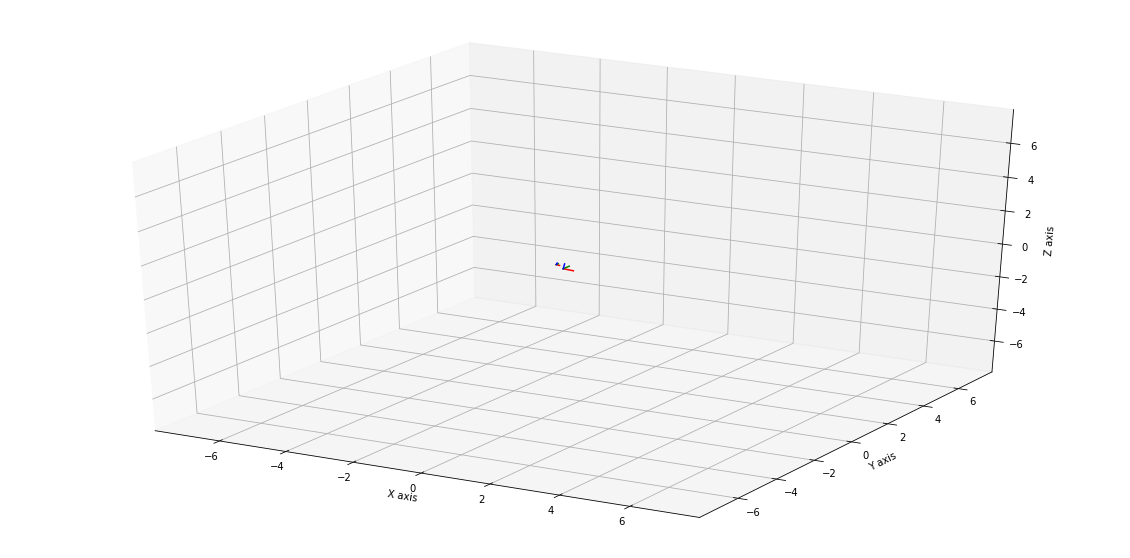

<Figure size 1440x720 with 0 Axes>

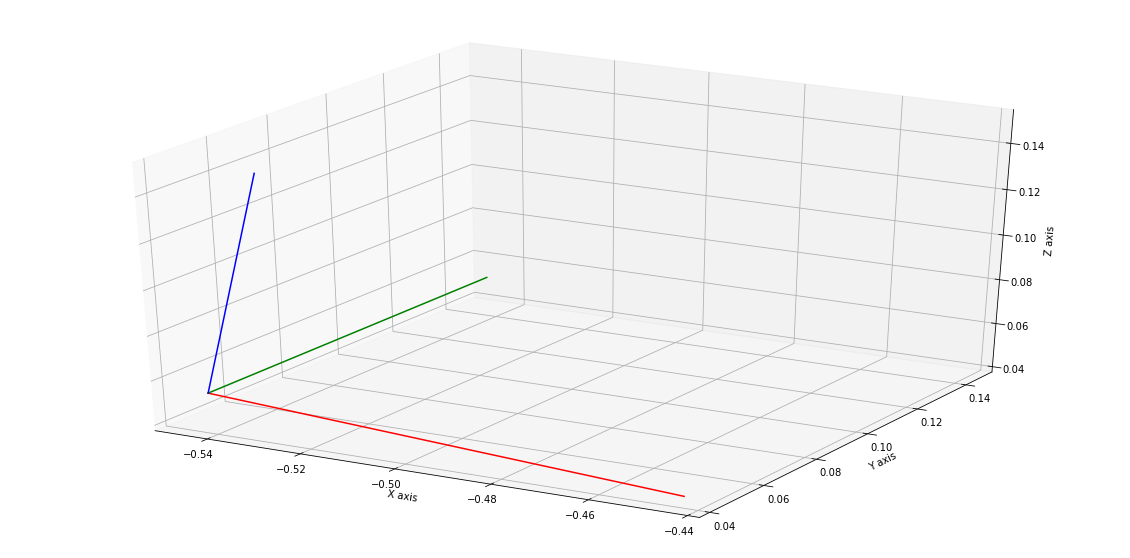

In [61]:
"""
GTSAM Copyright 2010-2019, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
See LICENSE for the license information
A script validating the Preintegration of IMU measurements
"""

import math

import gtsam
import matplotlib.pyplot as plt
import numpy as np
from gtsam.utils.plot import plot_pose3
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

IMU_FIG = 1
POSES_FIG = 2


class PreintegrationExample(object):

    @staticmethod
    def defaultParams(g):
        """Create default parameters with Z *up* and realistic noise parameters"""
        params = gtsam.PreintegrationParams.MakeSharedU(g)
        kGyroSigma = math.radians(0.5) / 60  # 0.5 degree ARW
        kAccelSigma = 0.1 / 60  # 10 cm VRW
        params.setGyroscopeCovariance(
            kGyroSigma ** 2 * np.identity(3, np.float))
        params.setAccelerometerCovariance(
            kAccelSigma ** 2 * np.identity(3, np.float))
        params.setIntegrationCovariance(
            0.0000001 ** 2 * np.identity(3, np.float))
        return params

    def __init__(self, twist=None, bias=None, dt=1e-2):
        """Initialize with given twist, a pair(angularVelocityVector, velocityVector)."""

        # setup interactive plotting
        plt.ion()

        # Setup loop as default scenario
        if twist is not None:
            (W, V) = twist
        else:
            # default = loop with forward velocity 2m/s, while pitching up
            # with angular velocity 30 degree/sec (negative in FLU)
            W = np.array([0, -math.radians(30), 0])
            V = np.array([2, 0, 0])

        self.scenario = gtsam.ConstantTwistScenario(W, V)
        self.dt = dt

        self.maxDim = 5
        self.labels = list('xyz')
        self.colors = list('rgb')

        # Create runner
        self.g = 10  # simple gravity constant
        self.params = self.defaultParams(self.g)

        if bias is not None:
            self.actualBias = bias
        else:
            accBias = np.array([0, 0.1, 0])
            gyroBias = np.array([0, 0, 0])
            self.actualBias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

        self.runner = gtsam.ScenarioRunner(
            self.scenario, self.params, self.dt, self.actualBias)

        fig, self.axes = plt.subplots(4, 3)
        fig.set_tight_layout(True)

    def plotImu(self, t, measuredOmega, measuredAcc):
        plt.figure(IMU_FIG)

        # plot angular velocity
        omega_b = self.scenario.omega_b(t)
        for i, (label, color) in enumerate(zip(self.labels, self.colors)):
            ax = self.axes[0][i]
            ax.scatter(t, omega_b[i], color='k', marker='.')
            ax.scatter(t, measuredOmega[i], color=color, marker='.')
            ax.set_xlabel('angular velocity ' + label)

        # plot acceleration in nav
        acceleration_n = self.scenario.acceleration_n(t)
        for i, (label, color) in enumerate(zip(self.labels, self.colors)):
            ax = self.axes[1][i]
            ax.scatter(t, acceleration_n[i], color=color, marker='.')
            ax.set_xlabel('acceleration in nav ' + label)

        # plot acceleration in body
        acceleration_b = self.scenario.acceleration_b(t)
        for i, (label, color) in enumerate(zip(self.labels, self.colors)):
            ax = self.axes[2][i]
            ax.scatter(t, acceleration_b[i], color=color, marker='.')
            ax.set_xlabel('acceleration in body ' + label)

        # plot actual specific force, as well as corrupted
        actual = self.runner.actualSpecificForce(t)
        for i, (label, color) in enumerate(zip(self.labels, self.colors)):
            ax = self.axes[3][i]
            ax.scatter(t, actual[i], color='k', marker='.')
            ax.scatter(t, measuredAcc[i], color=color, marker='.')
            ax.set_xlabel('specific force ' + label)

    def plotGroundTruthPose(self, t, scale=0.3, time_interval=0.01):
        # plot ground truth pose, as well as prediction from integrated IMU measurements
        actualPose = self.scenario.pose(t)
        plot_pose3(POSES_FIG, actualPose, scale)
        t = actualPose.translation()
        self.maxDim = max([max(np.abs(t)), self.maxDim])
        ax = plt.gca()
        ax.set_xlim3d(-self.maxDim, self.maxDim)
        ax.set_ylim3d(-self.maxDim, self.maxDim)
        ax.set_zlim3d(-self.maxDim, self.maxDim)

        plt.pause(time_interval)

    def run(self, T=12):
        # simulate the loop
        for i, t in enumerate(np.arange(0, T, self.dt)):
            measuredOmega = self.runner.measuredAngularVelocity(t)
            measuredAcc = self.runner.measuredSpecificForce(t)
            if i % 25 == 0:
                clear_output(wait=True)
                self.plotImu(t, measuredOmega, measuredAcc)
                self.plotGroundTruthPose(t)
                pim = self.runner.integrate(t, self.actualBias, True)
                predictedNavState = self.runner.predict(pim, self.actualBias)
                plot_pose3(POSES_FIG, predictedNavState.pose(), 0.1)

        plt.ioff()
        plt.show()


if __name__ == '__main__':
    PreintegrationExample().run()

In [17]:
accBias = np.array([-0.3, 0.1, 0.2])
gyroBias = np.array([0.1, 0.3, -0.1])
gtsam.imuBias.ConstantBias(accBias, gyroBias)

acc = -0.3
 0.1
 0.2 gyro =  0.1
 0.3
-0.1

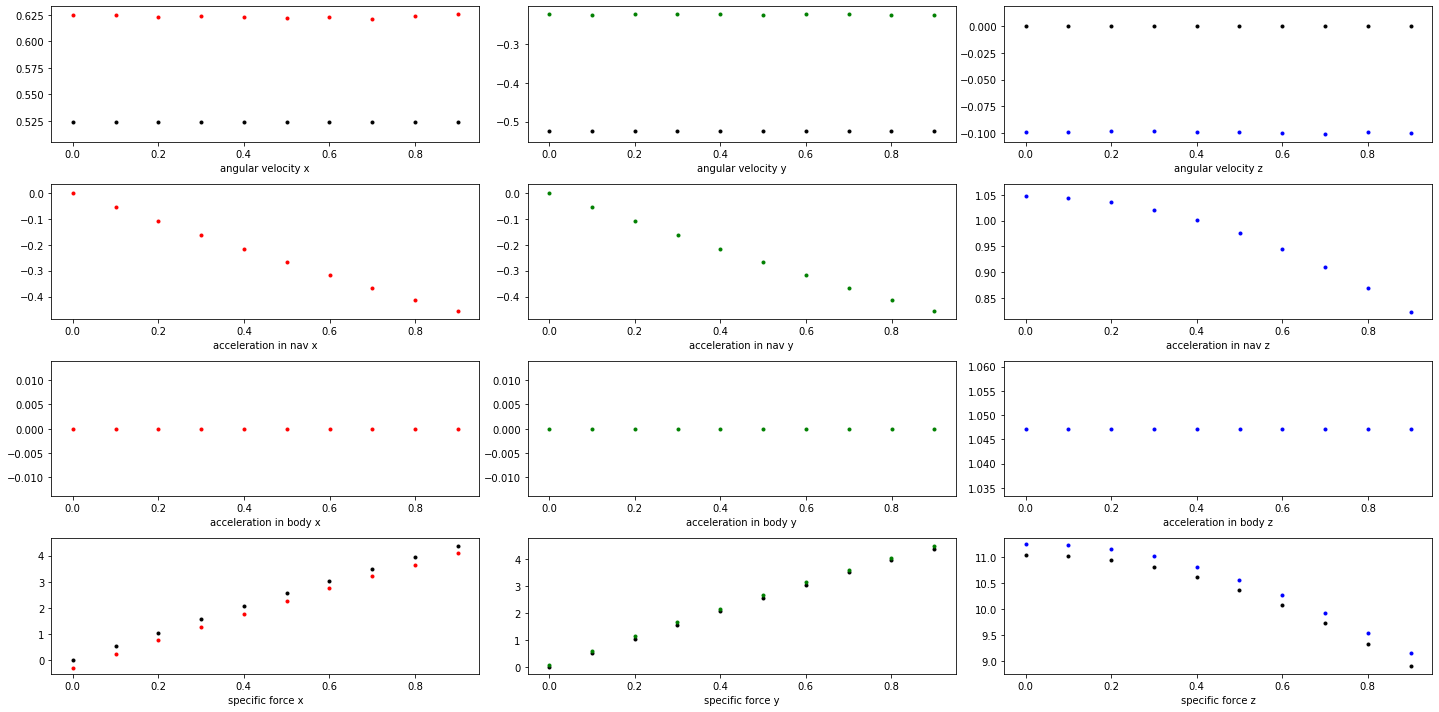

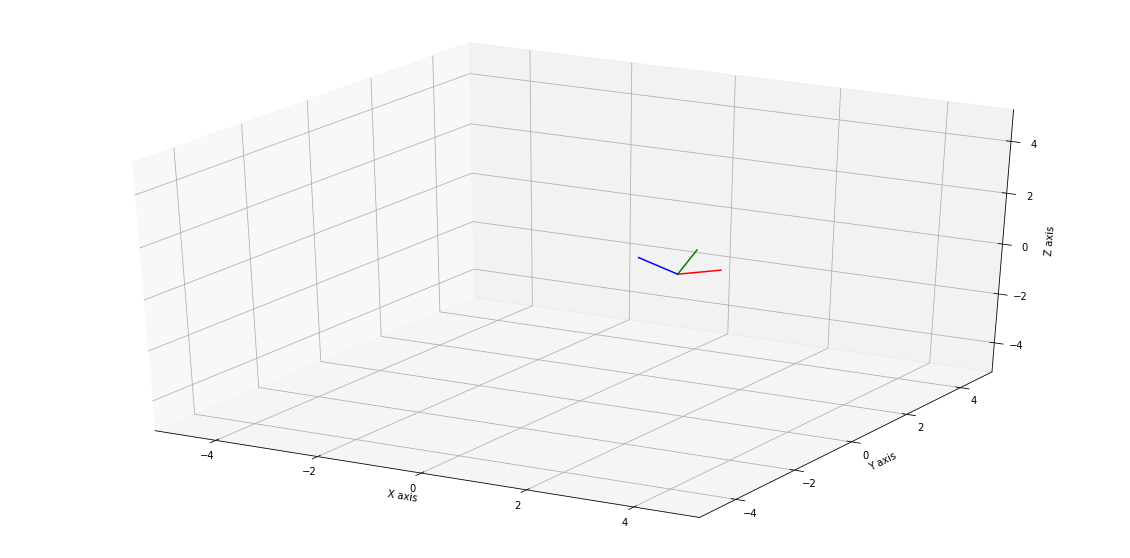

ImuFactor(x0,v0,x1,v1,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149189 -0.497256   0.57348)
    deltaPij -0.0878374
-0.0856852
   5.49942
    deltaVij -0.260391
-0.255567
  10.9542
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16504e-08  4.96374e-10 -2.27738e-13 -6.32926e-10 -3.74319e-08 -8.99059e-10 -1.67637e-09 -1.12557e-07 -3.56749e-09
 4.96374e-10  2.16503e-08  2.27759e-13  3.74274e-08  6.37648e-10  9.15811e-10  1.12542e-07  1.68953e-09  3.62181e-09
-2.27738e-13  2.27759e-13  2.21467e-08 -9.10561e-09  9.08916e-09 -4.53237e-12 -2.64955e-08  2.64423e-08 -1.46503e-11
-6.32926e-10  3.74274e-08 -9.10561e-09  1.05021e-06 -6.43641e-11  2.66569e-09  1.69981e-06 -2.19974e-10  8.89386e-09
-3.74319e-08  6.37648e-10  9.08916e-09 -6.43641e-11  1.05021e-06  2.61016e-09 -2.20634e-10  1.69982e-06  8.74576e-09
-8.99059e-10  9.15811e-10 -4.53237e-12  2.66569e-09  2.61016e-09   9.2602e-07  6.99089e-09  6.85124e-09  1.38929e-06
-1.67637e-0

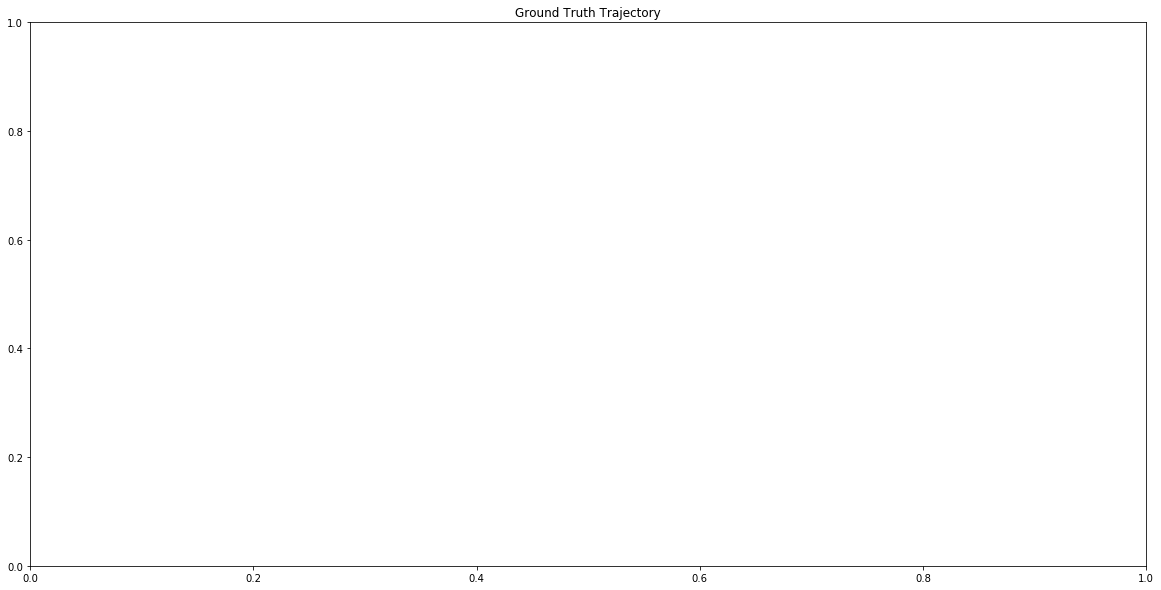

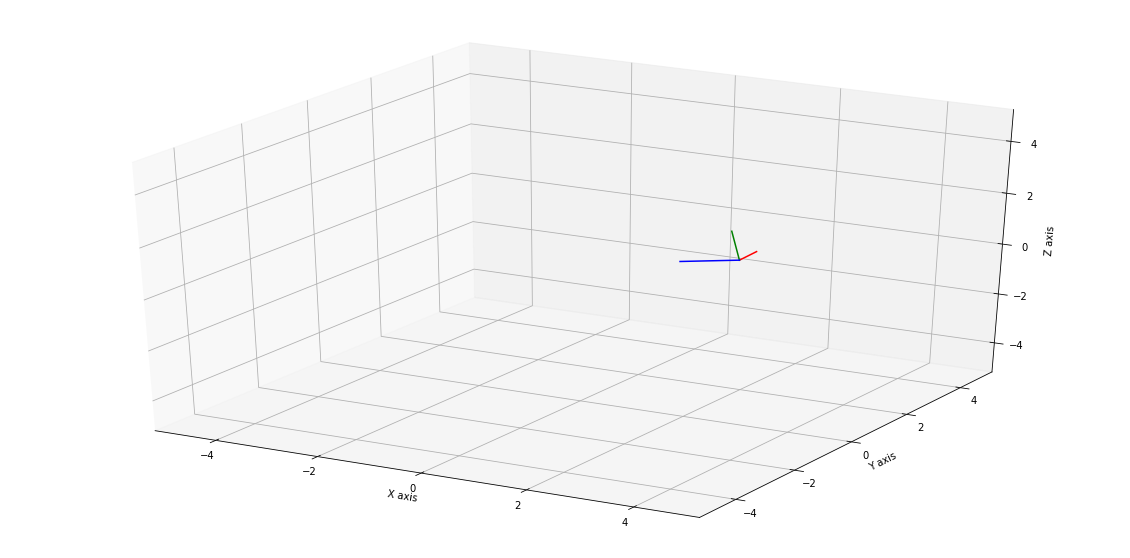

ImuFactor(x1,v1,x2,v2,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149357 -0.497272  0.573618)
    deltaPij 2.29677
 2.2974
4.19091
    deltaVij  4.5106
4.51002
8.33645
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16505e-08  4.96521e-10 -1.18155e-13 -4.75951e-09 -2.42133e-08   1.5648e-08 -1.41172e-08 -7.26836e-08  4.63263e-08
 4.96521e-10  2.16505e-08  1.18158e-13  2.42143e-08  4.76337e-09 -1.56522e-08  7.26915e-08  1.41336e-08 -4.63567e-08
-1.18155e-13  1.18158e-13   2.2147e-08 -2.25162e-08  2.25185e-08  6.36849e-13 -6.69249e-08  6.69495e-08  6.76566e-12
-4.75951e-09  2.42143e-08 -2.25162e-08  1.01917e-06 -2.12168e-08 -3.90915e-08  1.62107e-06 -5.22916e-08 -9.65213e-08
-2.42133e-08  4.76337e-09  2.25185e-08 -2.12168e-08  1.01917e-06 -3.90941e-08 -5.22729e-08  1.62109e-06 -9.64853e-08
  1.5648e-08 -1.56522e-08  6.36849e-13 -3.90915e-08 -3.90941e-08  9.68325e-07 -9.74309e-08 -9.74295e-08  1.49342e-06
-1.41172e-08  7.26915e-08 

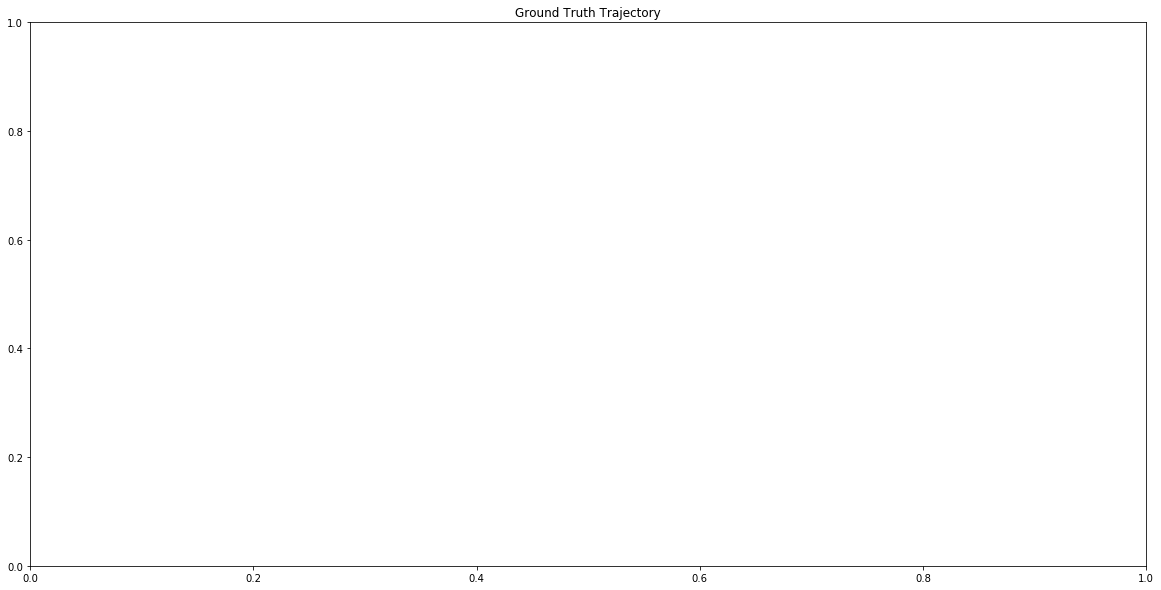

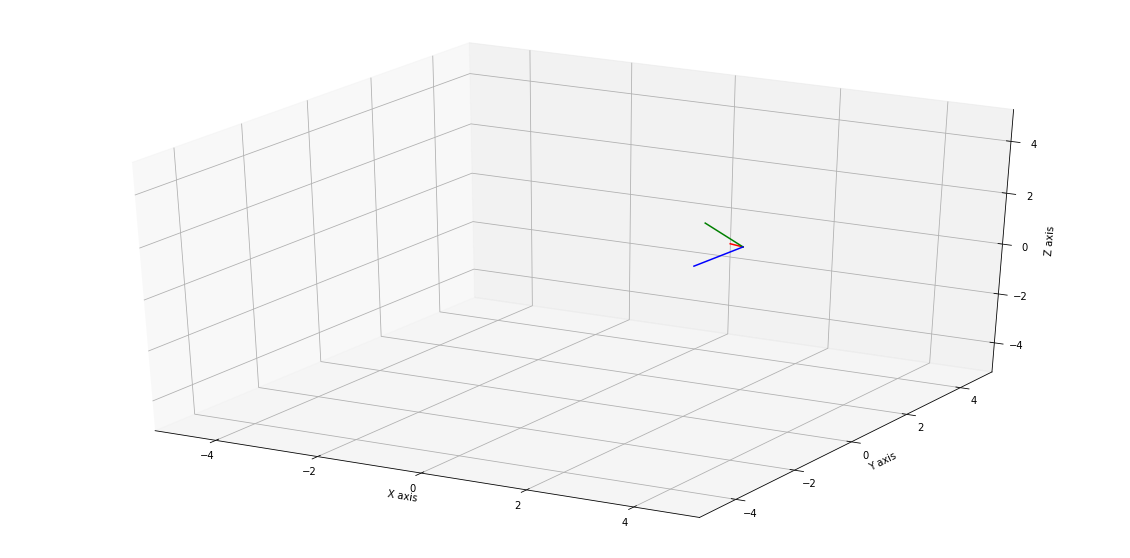

ImuFactor(x2,v2,x3,v3,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149288 -0.497051  0.573498)
    deltaPij  3.43556
 3.43444
0.949142
    deltaVij 6.78674
6.78605
1.85269
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16501e-08   4.9622e-10 -8.72832e-14 -6.31047e-09 -1.50098e-10  2.35503e-08 -1.87976e-08 -1.21868e-10  7.01792e-08
  4.9622e-10  2.16503e-08  8.72555e-14  1.49773e-10  6.31376e-09 -2.35566e-08  1.14834e-10  1.88013e-08  -7.0176e-08
-8.72832e-14  8.72555e-14  2.21464e-08 -2.41628e-08  2.41668e-08  3.07937e-12 -7.19107e-08  7.19004e-08  3.10281e-12
-6.31047e-09  1.49773e-10 -2.41628e-08   9.7736e-07 -4.78406e-08 -1.31782e-08  1.51641e-06 -1.18659e-07 -3.26384e-08
-1.50098e-10  6.31376e-09  2.41668e-08 -4.78406e-08  9.77386e-07 -1.31745e-08 -1.18688e-07  1.51644e-06 -3.26385e-08
 2.35503e-08 -2.35566e-08  3.07937e-12 -1.31782e-08 -1.31745e-08  1.02157e-06 -3.22115e-08 -3.22037e-08  1.62621e-06
-1.87976e-08  1.14834e-

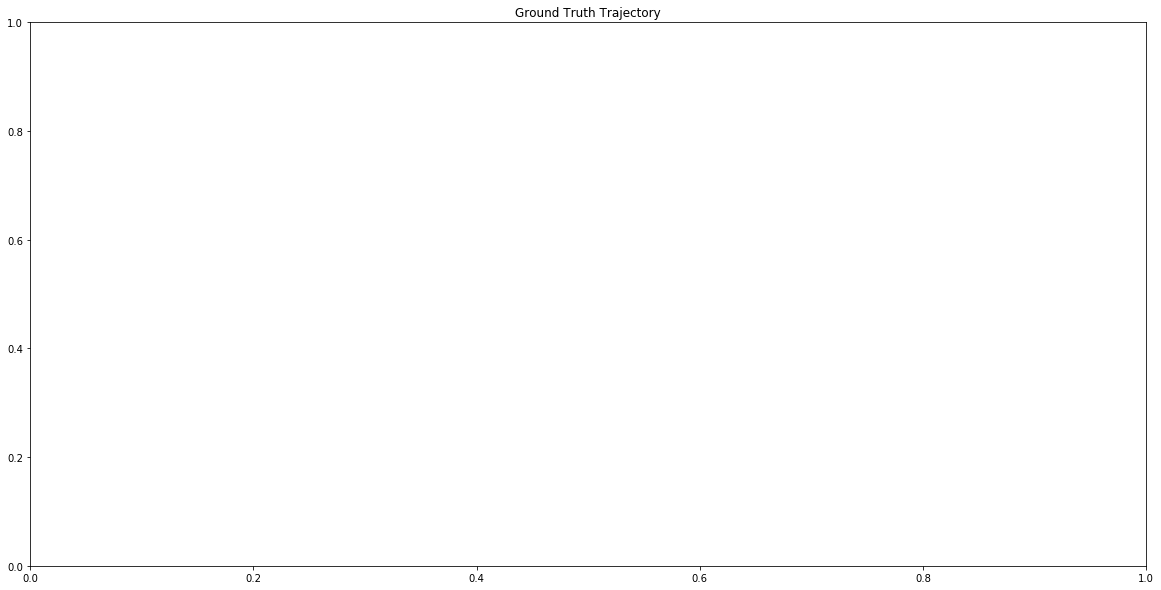

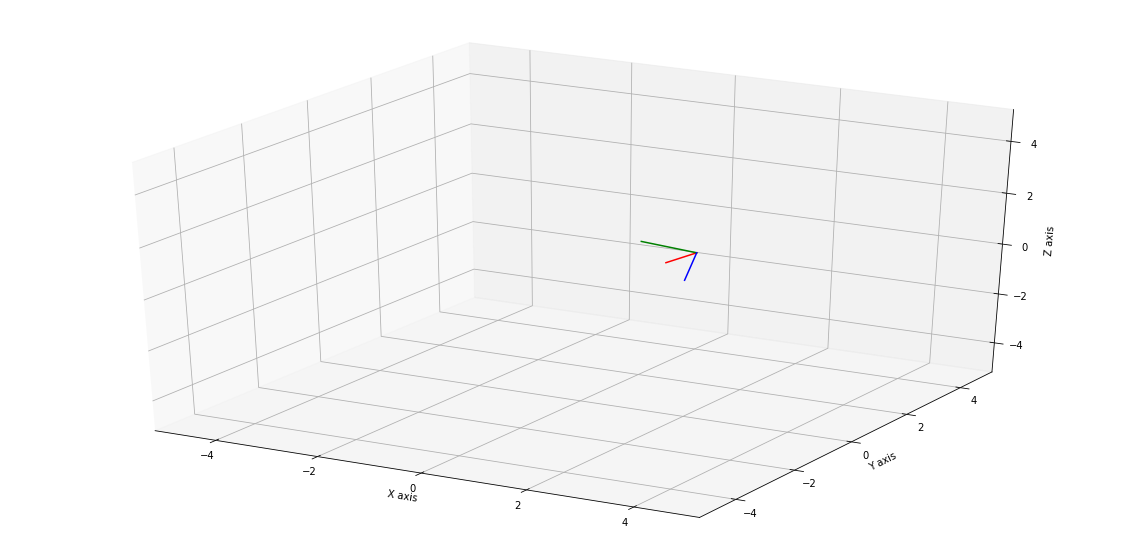

ImuFactor(x3,v3,x4,v4,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149615 -0.497288  0.573818)
    deltaPij  2.72558
 2.72389
-2.52674
    deltaVij 5.36774
5.36376
-5.0985
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16507e-08  4.96728e-10  6.13172e-14 -4.46752e-09  2.21458e-08  1.86151e-08 -1.32324e-08  6.71104e-08  5.52795e-08
 4.96728e-10  2.16507e-08 -6.13143e-14 -2.21421e-08  4.47294e-09 -1.86284e-08 -6.70986e-08  1.32493e-08 -5.53215e-08
 6.13172e-14 -6.13143e-14  2.21474e-08 -1.31324e-08  1.31469e-08  4.04279e-12 -3.86327e-08  3.86786e-08   1.2728e-11
-4.46752e-09 -2.21421e-08 -1.31324e-08  9.82409e-07 -2.99691e-08  2.82202e-08  1.53036e-06 -7.40878e-08  6.99833e-08
 2.21458e-08  4.47294e-09  1.31469e-08 -2.99691e-08  9.82456e-07  2.81978e-08 -7.40847e-08  1.53048e-06  6.99241e-08
 1.86151e-08 -1.86284e-08  4.04279e-12  2.82202e-08  2.81978e-08  9.85833e-07  7.14313e-08  7.13738e-08  1.53704e-06
-1.32324e-08 -6.70986e-

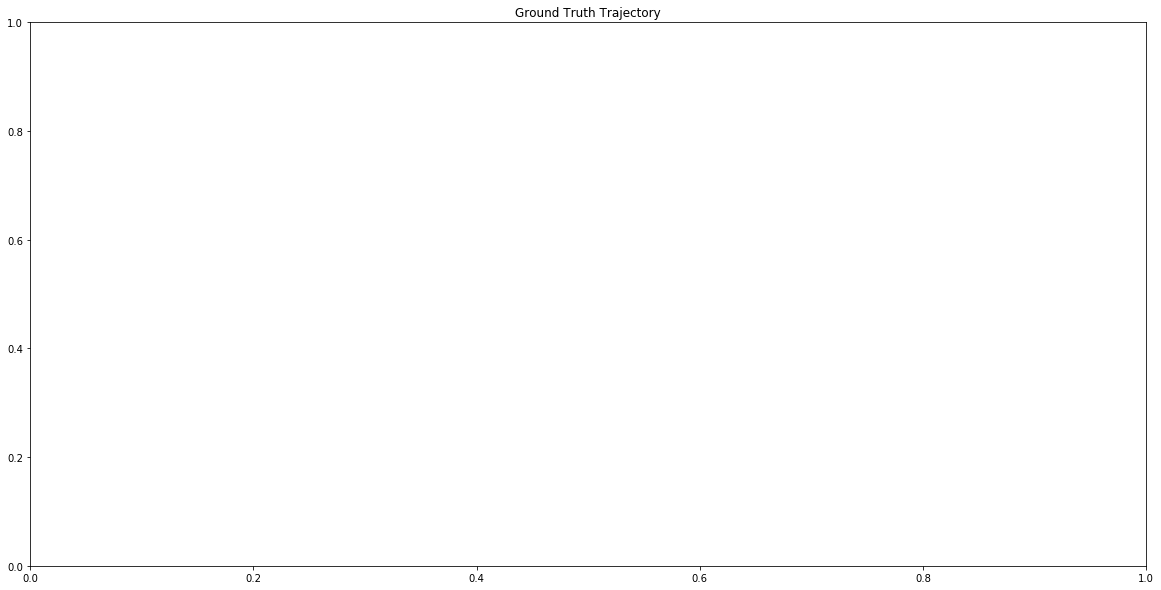

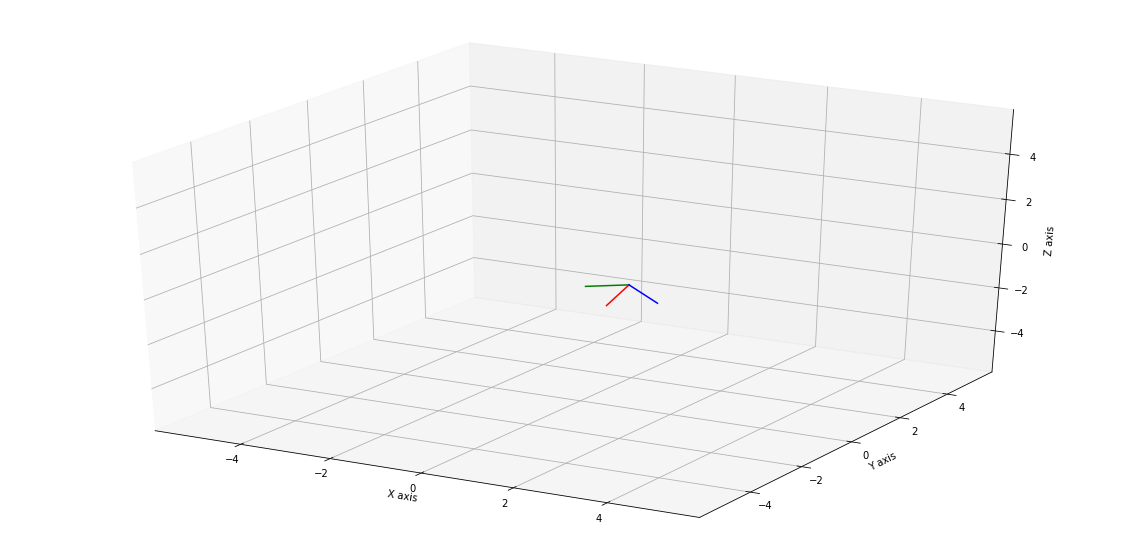

ImuFactor(x4,v4,x5,v5,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149345 -0.497077  0.573797)
    deltaPij 0.543782
0.543553
-4.42041
    deltaVij  1.00284
 1.00356
-8.88726
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16502e-08  4.96534e-10 -1.14388e-13 -2.03413e-10  3.10394e-08  3.47272e-09 -3.74892e-10  9.39172e-08  9.62385e-09
 4.96534e-10  2.16509e-08  1.14302e-13 -3.10394e-08  1.99844e-10 -3.47162e-09 -9.39211e-08  3.59867e-10 -9.60573e-09
-1.14388e-13  1.14302e-13  2.21471e-08  4.76217e-09 -4.75756e-09  2.91095e-13  1.53159e-08 -1.53167e-08 -3.33401e-12
-2.03413e-10 -3.10394e-08  4.76217e-09  1.00804e-06  -1.0965e-09  9.40035e-09   1.5963e-06 -2.52191e-09  2.18451e-08
 3.10394e-08  1.99844e-10 -4.75756e-09  -1.0965e-09  1.00804e-06  9.39604e-09 -2.52549e-09   1.5963e-06  2.18733e-08
 3.47272e-09 -3.47162e-09  2.91095e-13  9.40035e-09  9.39604e-09  9.28088e-07  2.34824e-08  2.34795e-08  1.39391e-06
-3.74892e-10 -9.3921

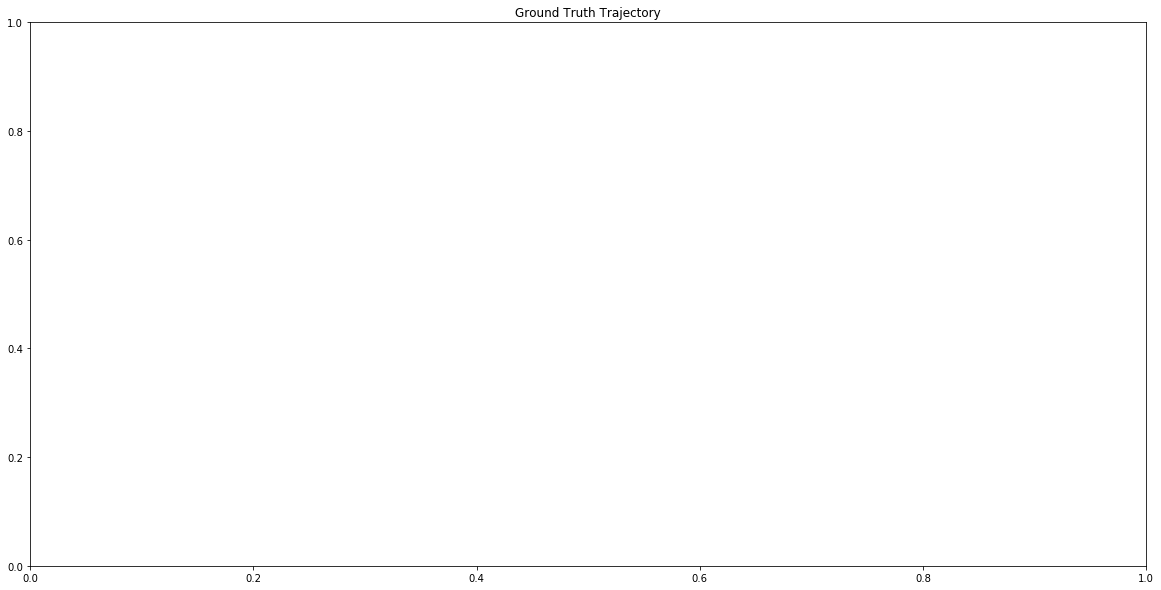

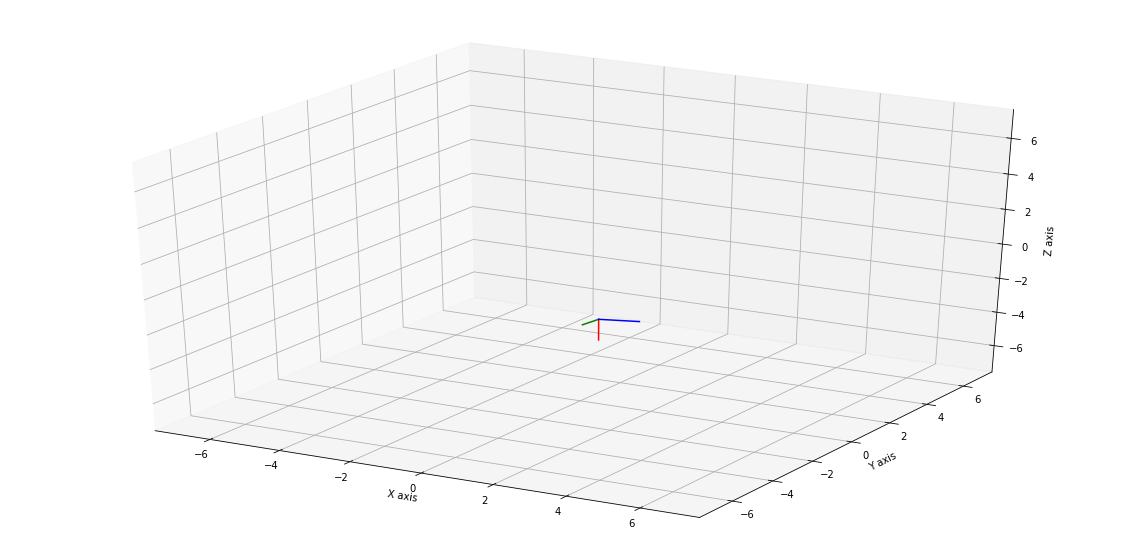

ImuFactor(x5,v5,x6,v6,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = ( -0.14931 -0.497216  0.573446)
    deltaPij -1.96727
-1.96879
-3.73267
    deltaVij -4.01904
 -4.0219
-7.51111
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16504e-08  4.96308e-10 -1.00247e-13  4.25495e-09  2.17989e-08 -1.39779e-08  1.30699e-08  6.60676e-08 -4.30029e-08
 4.96308e-10  2.16502e-08  1.00264e-13 -2.17985e-08 -4.25547e-09  1.39743e-08 -6.60635e-08 -1.30684e-08  4.29811e-08
-1.00247e-13  1.00264e-13  2.21466e-08  2.01562e-08 -2.01521e-08  1.97268e-12  6.17397e-08 -6.17161e-08  9.06137e-12
 4.25495e-09 -2.17985e-08  2.01562e-08  1.00021e-06 -1.64776e-08 -3.08555e-08  1.57756e-06 -4.23155e-08 -7.90717e-08
 2.17989e-08 -4.25547e-09 -2.01521e-08 -1.64776e-08  1.00019e-06 -3.08664e-08 -4.23241e-08  1.57753e-06 -7.91154e-08
-1.39779e-08  1.39743e-08  1.97268e-12 -3.08555e-08 -3.08664e-08  9.58849e-07 -7.82549e-08 -7.82823e-08   1.4735e-06
 1.30699e-08 -6.6063

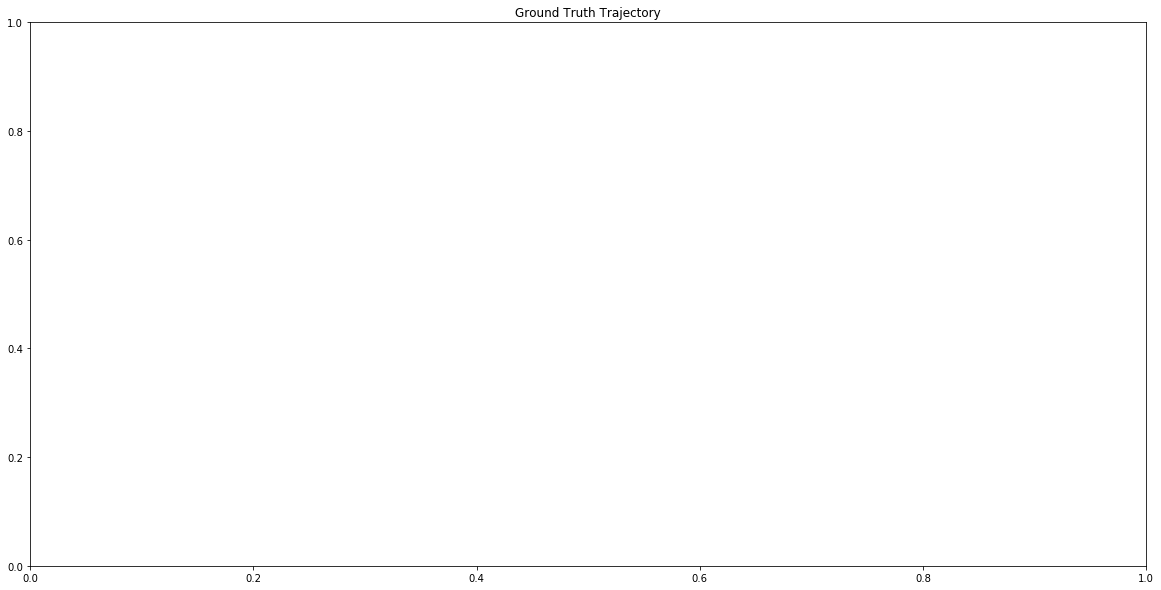

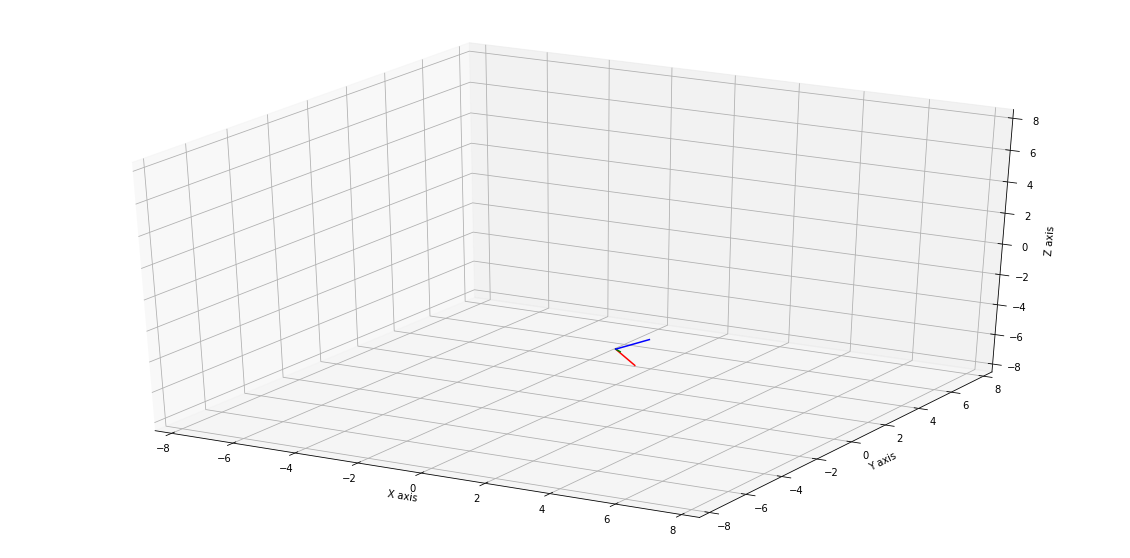

ImuFactor(x6,v6,x7,v7,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149382  -0.49713  0.573937)
    deltaPij  -3.49435
  -3.4964
-0.830653
    deltaVij -7.07232
 -7.0766
-1.70854
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16503e-08  4.96716e-10 -1.31237e-13  6.57151e-09 -6.64753e-10 -2.45905e-08   2.0047e-08 -1.64557e-09  -7.4982e-08
 4.96716e-10  2.16511e-08  1.31122e-13  6.75825e-10 -6.57132e-09  2.45714e-08  1.67349e-09 -2.00524e-08  7.49451e-08
-1.31237e-13  1.31122e-13  2.21474e-08  2.50095e-08 -2.49865e-08  4.05427e-13  7.63567e-08 -7.63079e-08    -4.62e-12
 6.57151e-09  6.75825e-10  2.50095e-08   9.8014e-07 -5.12702e-08 -1.22374e-08  1.52702e-06 -1.30443e-07 -3.11947e-08
-6.64753e-10 -6.57132e-09 -2.49865e-08 -5.12702e-08  9.80053e-07 -1.22478e-08  -1.3042e-07  1.52681e-06 -3.12169e-08
-2.45905e-08  2.45714e-08  4.05427e-13 -1.22374e-08 -1.22478e-08  1.02843e-06 -3.17211e-08 -3.17493e-08  1.64972e-06
  2.0047e-08  1.6

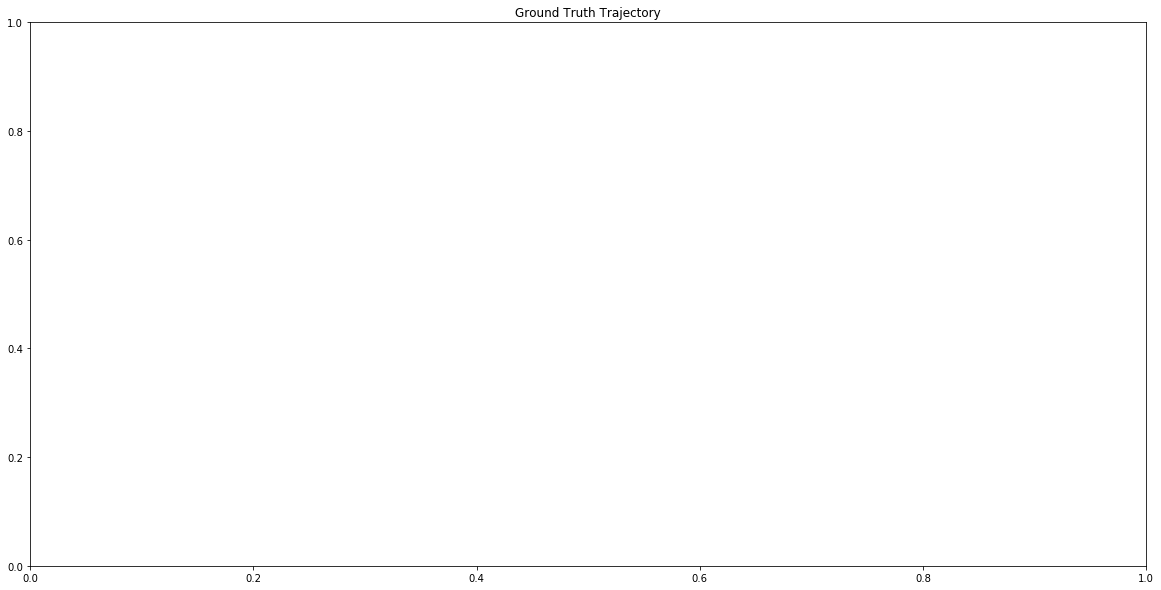

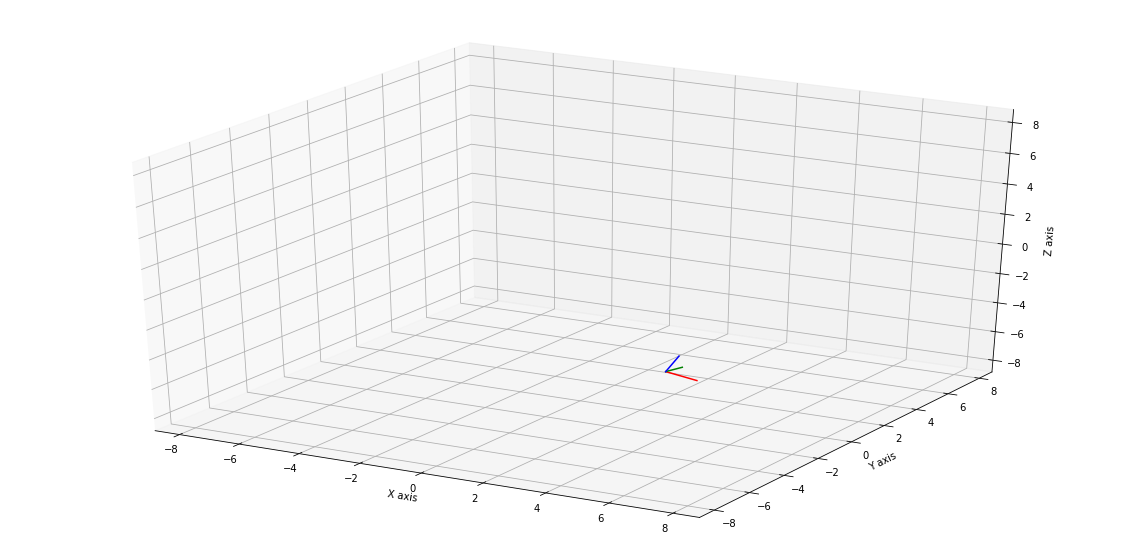

ImuFactor(x7,v7,x8,v8,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149471 -0.497416  0.573647)
    deltaPij -3.23894
-3.23856
 2.76918
    deltaVij -6.56021
-6.56021
  5.4929
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16509e-08  4.96667e-10 -6.09727e-14  5.53158e-09 -2.46323e-08 -2.27934e-08  1.69094e-08 -7.39415e-08 -6.95692e-08
 4.96667e-10  2.16505e-08  6.09857e-14  2.46296e-08 -5.52837e-09  2.27973e-08   7.3937e-08  -1.6896e-08  6.95673e-08
-6.09727e-14  6.09857e-14  2.21473e-08  1.67484e-08 -1.67485e-08  1.70582e-12  5.14445e-08 -5.14312e-08  8.96841e-12
 5.53158e-09  2.46296e-08  1.67484e-08  1.00134e-06 -4.40734e-08  3.71748e-08  1.57916e-06 -1.12203e-07  9.43856e-08
-2.46323e-08 -5.52837e-09 -1.67485e-08 -4.40734e-08  1.00134e-06  3.71742e-08 -1.12216e-07  1.57916e-06  9.43913e-08
-2.27934e-08  2.27973e-08  1.70582e-12  3.71748e-08  3.71742e-08  1.01404e-06  9.27737e-08  9.27689e-08  1.61327e-06
 1.69094e-08   7.393

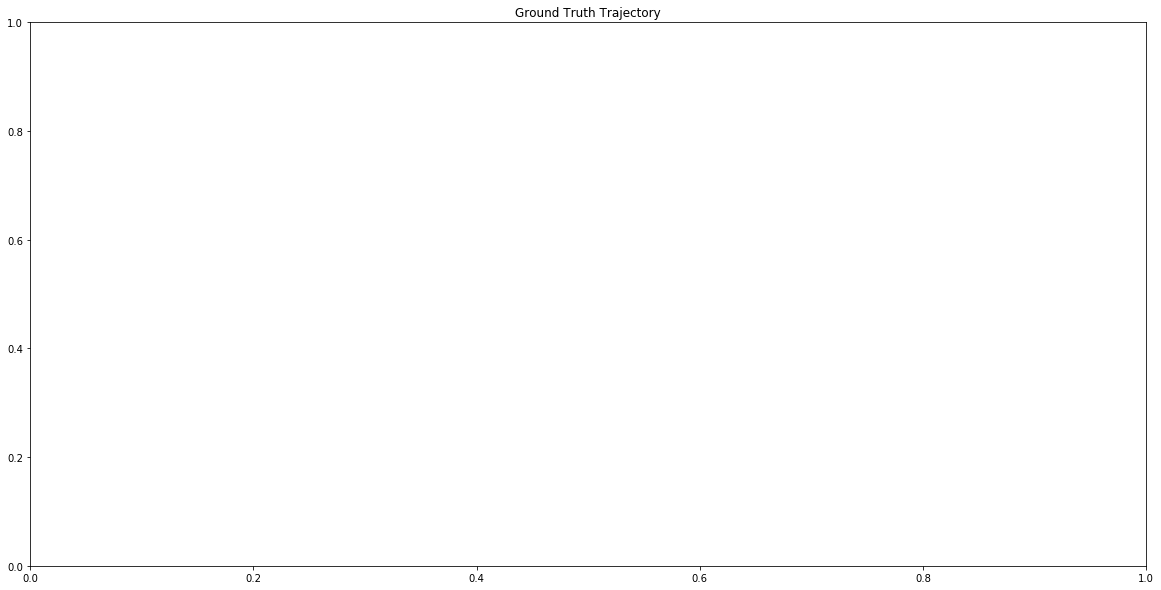

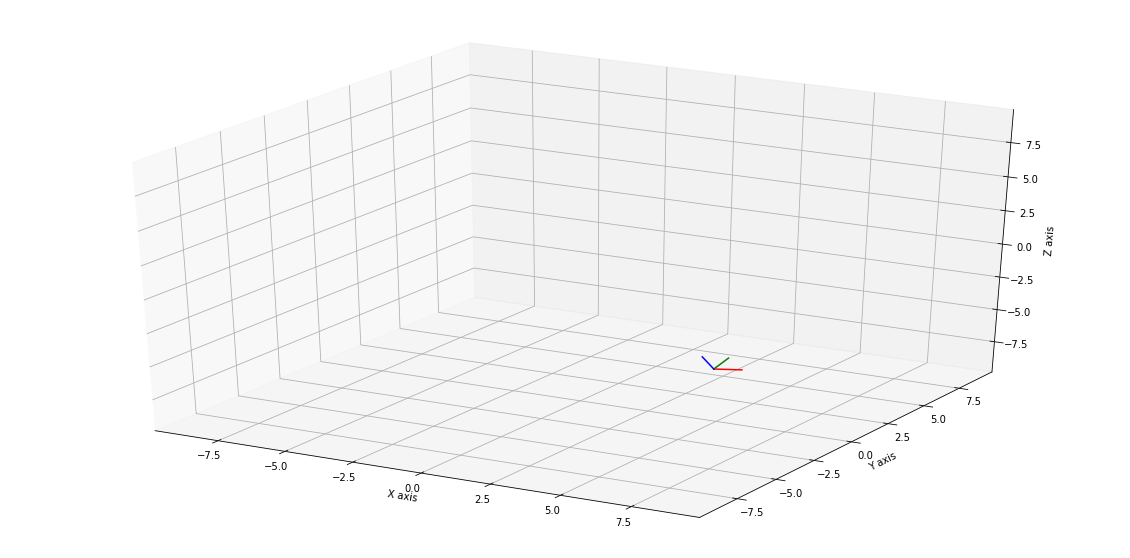

ImuFactor(x8,v8,x9,v9,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149593 -0.497163  0.573726)
    deltaPij -1.32962
-1.33024
 5.18171
    deltaVij -2.74337
-2.74617
 10.3184
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16505e-08  4.96535e-10  1.00335e-13  1.67428e-09  -3.7542e-08 -9.54683e-09  5.28676e-09 -1.12852e-07 -2.96627e-08
 4.96535e-10  2.16506e-08 -1.00317e-13  3.75439e-08 -1.67691e-09  9.53976e-09  1.12864e-07  -5.2876e-09  2.96156e-08
 1.00335e-13 -1.00317e-13  2.21471e-08 -2.81526e-10  2.86461e-10  1.36281e-12   1.3802e-10 -9.74099e-11    1.114e-11
 1.67428e-09  3.75439e-08 -2.81526e-10  1.04386e-06 -7.63723e-09  2.90031e-08   1.6845e-06 -1.98158e-08  7.48886e-08
 -3.7542e-08 -1.67691e-09  2.86461e-10 -7.63723e-09  1.04386e-06  2.90161e-08 -1.98297e-08  1.68446e-06  7.49793e-08
-9.54683e-09  9.53976e-09  1.36281e-12  2.90031e-08  2.90161e-08  9.41165e-07  7.28371e-08  7.28745e-08   1.4285e-06
 5.28676e-09  1.1286

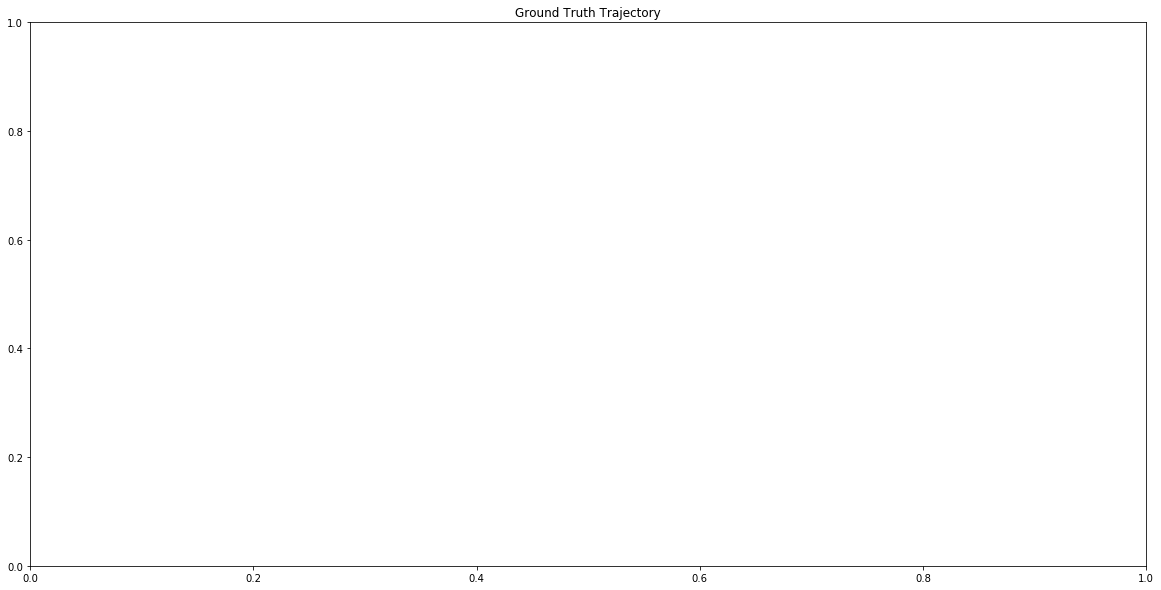

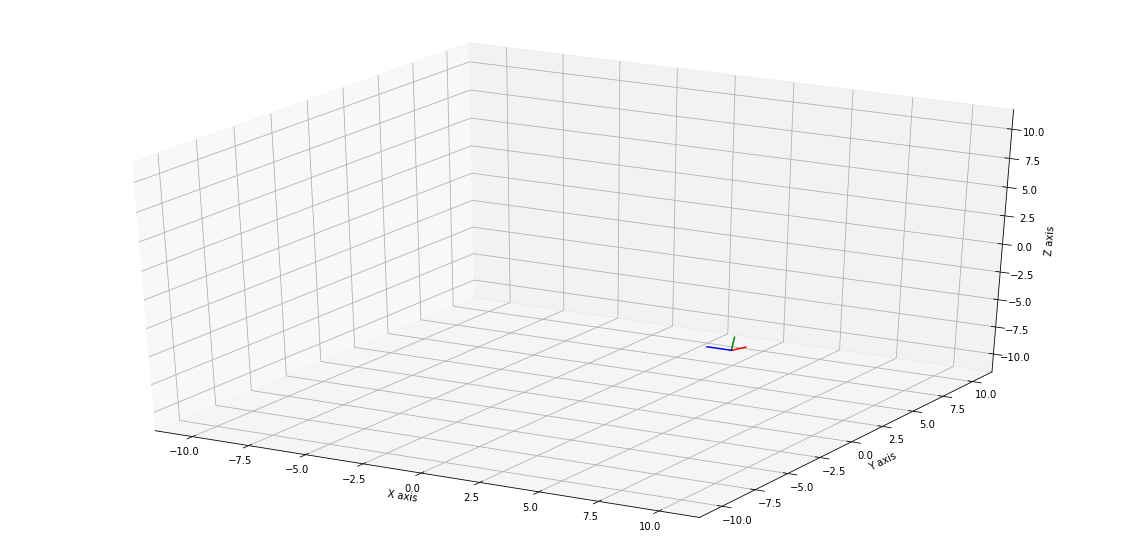

ImuFactor(x9,v9,x10,v10,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149347 -0.497136  0.573723)
    deltaPij 1.22694
1.22943
5.14092
    deltaVij 2.36973
2.37431
10.2363
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16503e-08  4.96511e-10 -1.11414e-13 -2.96971e-09 -3.26117e-08  8.23623e-09 -8.71787e-09 -9.79932e-08  2.39655e-08
 4.96511e-10  2.16507e-08  1.11378e-13  3.26048e-08  2.96958e-09 -8.21791e-09  9.79771e-08  8.72173e-09 -2.39262e-08
-1.11414e-13  1.11378e-13   2.2147e-08  -1.7175e-08  1.71513e-08 -4.20446e-12 -5.08052e-08    5.075e-08 -8.37632e-12
-2.96971e-09  3.26048e-08  -1.7175e-08  1.04041e-06 -5.93554e-09 -2.53363e-08  1.67464e-06 -1.43702e-08 -6.15847e-08
-3.26117e-08  2.96958e-09  1.71513e-08 -5.93554e-09  1.04038e-06 -2.53995e-08 -1.43639e-08  1.67457e-06 -6.17113e-08
 8.23623e-09 -8.21791e-09 -4.20446e-12 -2.53363e-08 -2.53995e-08  9.37762e-07 -6.30635e-08 -6.32211e-08  1.41759e-06
-8.71787e-09  9.79771e-0

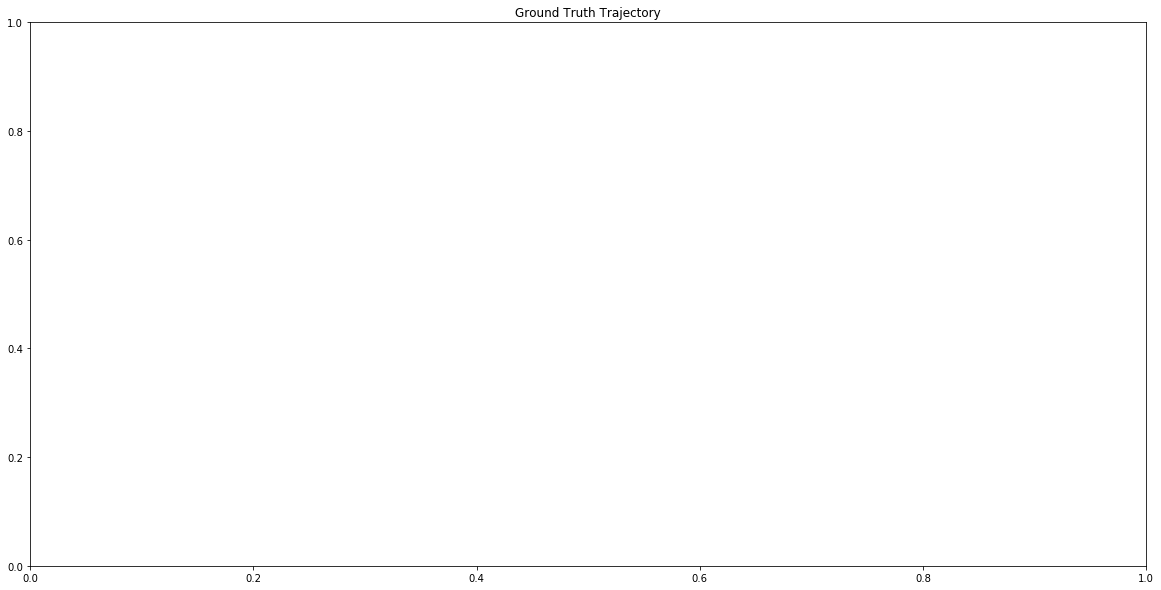

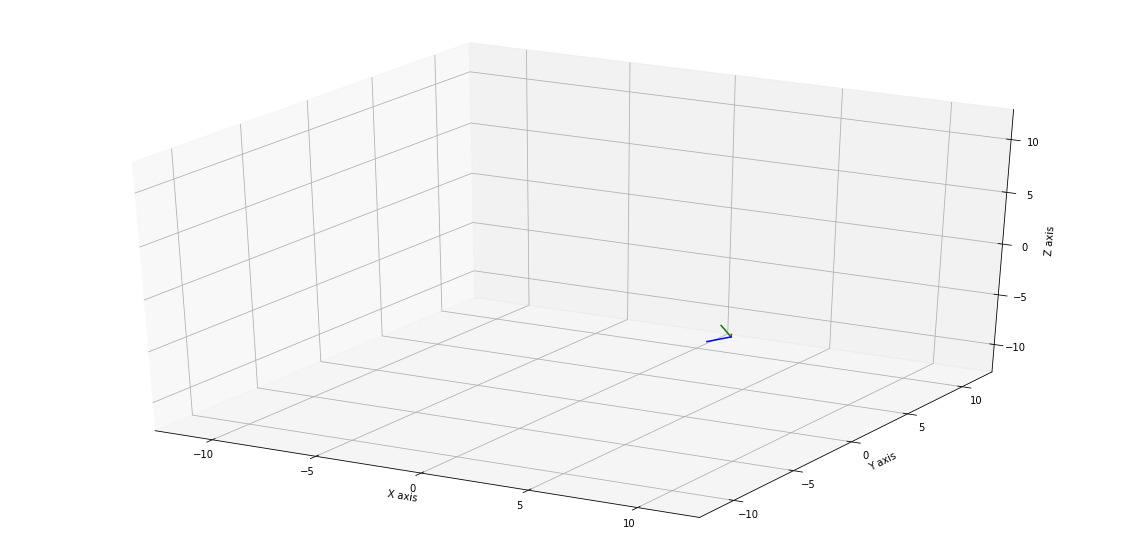

ImuFactor(x10,v10,x11,v11,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149638 -0.497041  0.573581)
    deltaPij 3.09645
3.09672
2.67093
    deltaVij 6.11064
6.10932
5.29671
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16502e-08  4.96294e-10  2.11451e-13  -5.9743e-09  -1.2456e-08  2.12091e-08  -1.7777e-08 -3.72062e-08  6.30905e-08
 4.96294e-10  2.16503e-08 -2.11412e-13  1.24559e-08  5.97209e-09 -2.12078e-08   3.7212e-08  1.77761e-08 -6.31078e-08
 2.11451e-13 -2.11412e-13  2.21466e-08 -2.50576e-08  2.50611e-08  1.07743e-12 -7.45758e-08  7.46072e-08  8.96738e-12
 -5.9743e-09  1.24559e-08 -2.50576e-08  9.93923e-07 -3.88229e-08 -3.36685e-08  1.55766e-06 -9.61783e-08 -8.34755e-08
 -1.2456e-08  5.97209e-09  2.50611e-08 -3.88229e-08  9.93929e-07 -3.36659e-08 -9.61522e-08  1.55771e-06 -8.34431e-08
 2.12091e-08 -2.12078e-08  1.07743e-12 -3.36685e-08 -3.36659e-08  1.00354e-06 -8.36804e-08 -8.36706e-08  1.58119e-06
 -1.7777e-08   3.7212e

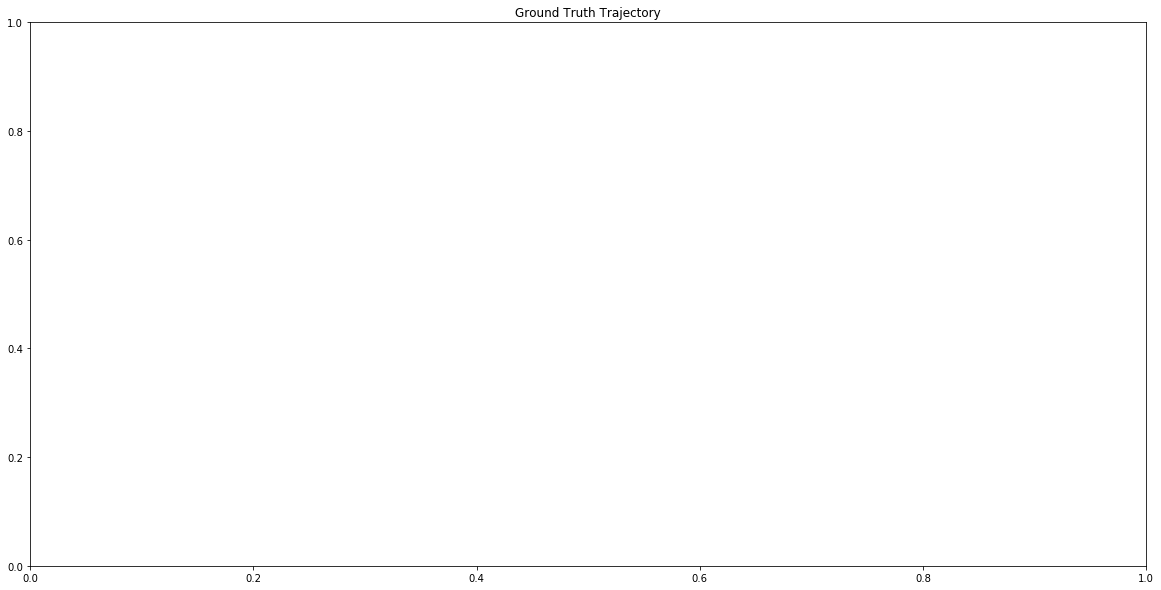

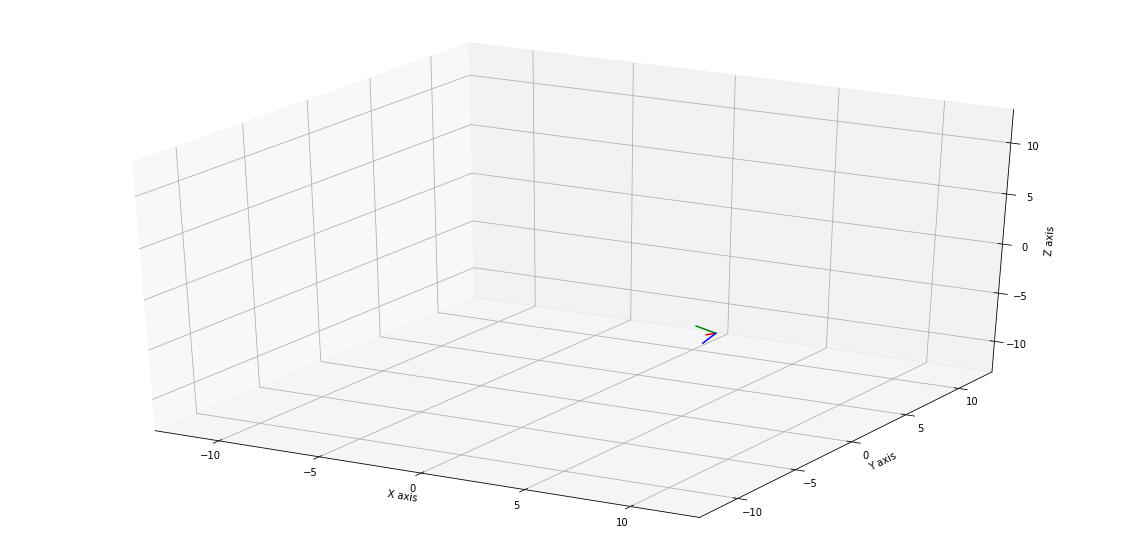

ImuFactor(x11,v11,x12,v12,b0)
preintegrated measurements:

    deltaTij 1
    deltaRij.ypr = (-0.149669 -0.497194  0.574035)
    deltaPij   3.29741
  3.29865
-0.933074
    deltaVij  6.51098
 6.51333
-1.91374
    gyrobias  0.1
 0.3
-0.1
    acc_bias -0.3
 0.1
 0.2

    preintMeasCov 
[ 2.16506e-08  4.96862e-10  8.46492e-14 -5.76537e-09  1.23823e-08  2.26056e-08 -1.71483e-08  3.76861e-08  6.73177e-08
 4.96862e-10  2.16511e-08 -8.45963e-14 -1.23863e-08  5.76891e-09 -2.26008e-08 -3.77022e-08  1.71546e-08 -6.72879e-08
 8.46492e-14 -8.45963e-14  2.21477e-08 -1.98335e-08  1.98322e-08  2.60425e-12 -5.88385e-08  5.88193e-08  3.48811e-12
-5.76537e-09 -1.23863e-08 -1.98335e-08  9.73662e-07 -4.40717e-08   1.2738e-08   1.5077e-06  -1.0925e-07  3.17304e-08
 1.23823e-08  5.76891e-09  1.98322e-08 -4.40717e-08  9.73654e-07  1.27391e-08 -1.09268e-07  1.50766e-06  3.17386e-08
 2.26056e-08 -2.26008e-08  2.60425e-12   1.2738e-08  1.27391e-08  1.01404e-06  3.27976e-08  3.28005e-08  1.60738e-06
-1.71483e-08 

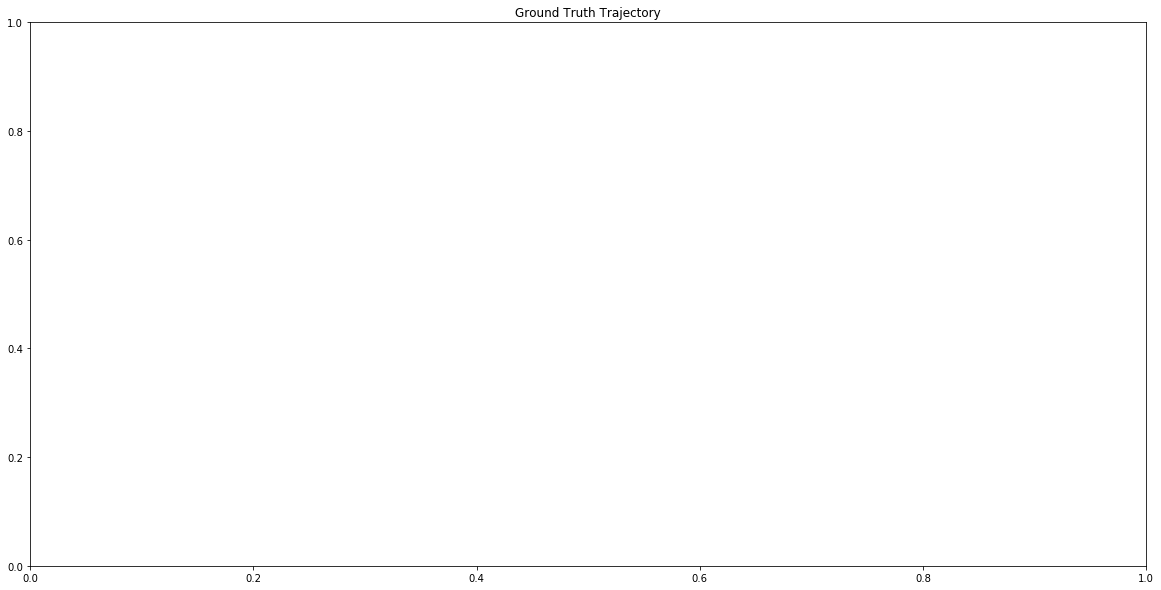

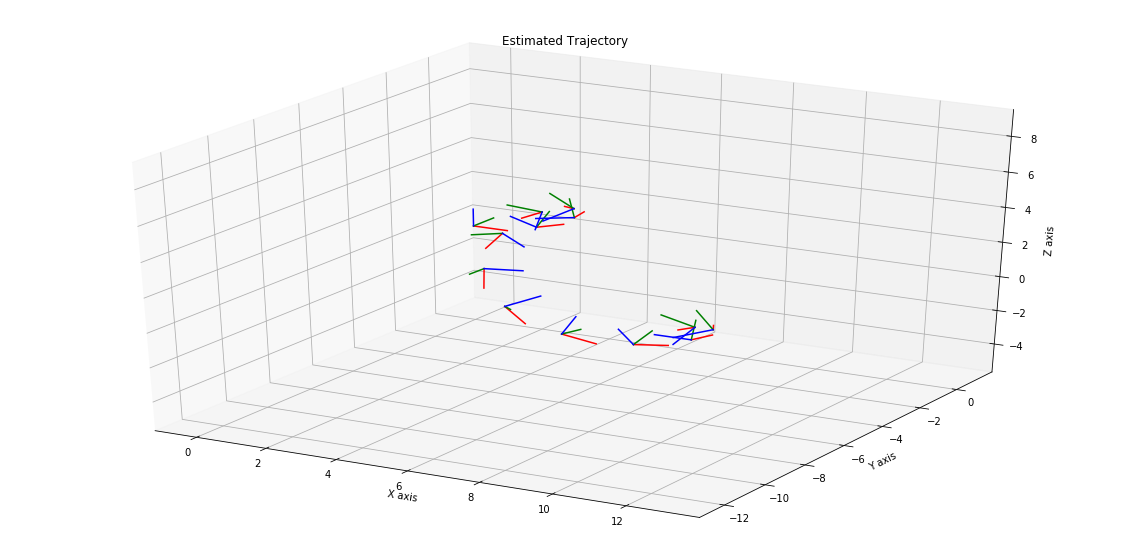

In [64]:
"""
GTSAM Copyright 2010-2019, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
See LICENSE for the license information
A script validating and demonstrating the ImuFactor inference.
Author: Frank Dellaert, Varun Agrawal
"""

from __future__ import print_function

import argparse
import math

import gtsam
import matplotlib.pyplot as plt
import numpy as np
from gtsam.symbol_shorthand import B, V, X
from gtsam.utils.plot import plot_pose3
from mpl_toolkits.mplot3d import Axes3D

# from PreintegrationExample import POSES_FIG, PreintegrationExample

BIAS_KEY = B(0)


np.set_printoptions(precision=3, suppress=True)


class ImuFactorExample(PreintegrationExample):

    def __init__(self, twist_scenario="sick_twist"):
        self.velocity = np.array([2, 0, 0])
        self.priorNoise = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)
        self.velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

        # Choose one of these twists to change scenario:
        twist_scenarios = dict(
            zero_twist=(np.zeros(3), np.zeros(3)),
            forward_twist=(np.zeros(3), self.velocity),
            loop_twist=(np.array([0, -math.radians(30), 0]), self.velocity),
            sick_twist=(np.array([math.radians(30), -math.radians(30), 0]),
                        self.velocity)
        )

        accBias = np.array([-0.3, 0.1, 0.2])
        gyroBias = np.array([0.1, 0.3, -0.1])
        bias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

        dt = 1e-2
        super(ImuFactorExample, self).__init__(twist_scenarios[twist_scenario],
                                               bias, dt)

    def addPrior(self, i, graph):
        state = self.scenario.navState(i)
        graph.push_back(gtsam.PriorFactorPose3(
            X(i), state.pose(), self.priorNoise))
        graph.push_back(gtsam.PriorFactorVector(
            V(i), state.velocity(), self.velNoise))

    def run(self, T=12, compute_covariances=False, verbose=True):
        graph = gtsam.NonlinearFactorGraph()

        # initialize data structure for pre-integrated IMU measurements
        pim = gtsam.PreintegratedImuMeasurements(self.params, self.actualBias)

        T = 12
        num_poses = T  # assumes 1 factor per second
        initial = gtsam.Values()
        initial.insert(BIAS_KEY, self.actualBias)

        # simulate the loop
        i = 0  # state index
        initial_state_i = self.scenario.navState(0)
        initial.insert(X(i), initial_state_i.pose())
        initial.insert(V(i), initial_state_i.velocity())

        # add prior on beginning
        self.addPrior(0, graph)

        for k, t in enumerate(np.arange(0, T, self.dt)):
            # get measurements and add them to PIM
            measuredOmega = self.runner.measuredAngularVelocity(t)
            measuredAcc = self.runner.measuredSpecificForce(t)
            pim.integrateMeasurement(measuredAcc, measuredOmega, self.dt)

            # Plot IMU many times
            if k % 10 == 0:
                self.plotImu(t, measuredOmega, measuredAcc)

            if (k+1) % int(1 / self.dt) == 0:
                # Plot every second
                self.plotGroundTruthPose(t, scale=1)
                plt.title("Ground Truth Trajectory")

                # create IMU factor every second
                factor = gtsam.ImuFactor(X(i), V(i),
                                         X(i + 1), V(i + 1),
                                         BIAS_KEY, pim)
                graph.push_back(factor)

                if verbose:
                    print(factor)
                    print(pim.predict(initial_state_i, self.actualBias))

                pim.resetIntegration()

                rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3)*0.1)
                translationNoise = gtsam.Point3(*np.random.randn(3)*1)
                poseNoise = gtsam.Pose3(rotationNoise, translationNoise)

                actual_state_i = self.scenario.navState(t + self.dt)
                print("Actual state at {0}:\n{1}".format(
                    t+self.dt, actual_state_i))

                noisy_state_i = gtsam.NavState(
                    actual_state_i.pose().compose(poseNoise),
                    actual_state_i.velocity() + np.random.randn(3)*0.1)
                print("noisy_state_i.velocity()", noisy_state_i.velocity())
                initial.insert(X(i+1), noisy_state_i.pose())
                initial.insert(V(i+1), noisy_state_i.velocity())
                i += 1

        # add priors on end
        self.addPrior(num_poses - 1, graph)

        initial.print_("Initial values:")

        # optimize using Levenberg-Marquardt optimization
        params = gtsam.LevenbergMarquardtParams()
        params.setVerbosityLM("SUMMARY")
        optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
        result = optimizer.optimize()

        result.print_("Optimized values:")

        if compute_covariances:
            # Calculate and print marginal covariances
            marginals = gtsam.Marginals(graph, result)
            print("Covariance on bias:\n",
                  marginals.marginalCovariance(BIAS_KEY))
            for i in range(num_poses):
                print("Covariance on pose {}:\n{}\n".format(
                    i, marginals.marginalCovariance(X(i))))
                print("Covariance on vel {}:\n{}\n".format(
                    i, marginals.marginalCovariance(V(i))))

        # Plot resulting poses
        i = 0
        while result.exists(X(i)):
            pose_i = result.atPose3(X(i))
            plot_pose3(POSES_FIG+1, pose_i, 1)
            i += 1
        plt.title("Estimated Trajectory")

        gtsam.utils.plot.set_axes_equal(POSES_FIG+1)

        print("Bias Values", result.atConstantBias(BIAS_KEY))

        plt.ioff()
        plt.show()


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser("ImuFactorExample.py")
#     parser.add_argument("--twist_scenario",
#                         default="sick_twist",
#                         choices=("zero_twist", "forward_twist", "loop_twist", "sick_twist"))
#     parser.add_argument("--time", "-T", default=12,
#                         type=int, help="Total time in seconds")
#     parser.add_argument("--compute_covariances",
#                         default=False, action='store_true')
#     parser.add_argument("--verbose", default=False, action='store_true')
#     args = parser.parse_args()

#     ImuFactorExample(args.twist_scenario).run(
#         args.time, args.compute_covariances, args.verbose)
ImuFactorExample().run()